## TODO


- Baysian hyper paramater optimization
- Increase model size
- Increase dropout
- Increase batch size and implement caching

# Imports

Import the required libraries.

In [1]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.pyplot import figure
import tensorflow as tf
import collections
import datetime
import timeit
import pandas as pd
import os
import glob
import random
from keras import backend as K
from keras import metrics
import numpy as np
from keras import mixed_precision
from keras import Input
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate, Conv2D
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU, LeakyReLU
from tensorflow.keras.layers import Add, concatenate, UpSampling2D, Lambda, multiply
from tensorflow.keras.models import Model, Sequential
import tensorflow_datasets as tfds
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, f1_score, auc
from matplotlib import pyplot
from skopt.space.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from plotnine import *
import plotnine
#### For testing purposes
# random.seed(1144)
random.seed(1)
###

In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [3]:
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'

In [4]:
policy = tf.keras.mixed_precision.Policy('mixed_float16')

tf.keras.mixed_precision.set_global_policy(policy)


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080, compute capability 8.6


In [5]:
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Load the dataset

Enter the Unix glob file pattern of the data files.

Here we load the training data. All the data are stored in TensorFlow Record files.
Replace 'train' with 'eval' or 'test' to load the evaluation or testing data, respectively.

Run the following three cells to define the required library functions for loading the data.

The first cell defines the name of the variables in the input files and the corrresponding data statistics. The statistics can be used for preprocessing the data. 

In [6]:
"""Constants for the data reader."""

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']


OUTPUT_FEATURES = ['detectionImage']

# Data statistics 
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, standard deviation)
DATA_STATS = {
    # Elevation in m.
    # 0.1 percentile, 99.9 percentile
    'elevation': (0.0, 3141.0, 657.3003, 649.0147),
    
    # Drought Index (Palmer Drought Severity Index)
    # 0.1 percentile, 99.9 percentile
    'pdsi': (-6.12974870967865, 7.876040384292651, -0.0052714925, 2.6823447),
    
    #Vegetation index (times 10,000 maybe, since it's supposed to be b/w -1 and 1?)
    'NDVI': (-9821.0, 9996.0, 5157.625, 2466.6677),  # min, max
   
    # Precipitation in mm.
    # Negative values do not make sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 44.53038024902344, 1.7398051, 4.482833),
   
    # Specific humidity.
    # Negative values do not make sense, so min is set to 0.
    # The range of specific humidity is up to 100% so max is 1.
    'sph': (0., 1., 0.0071658953, 0.0042835088),
    
    # Wind direction in degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th': (0., 360.0, 190.32976, 72.59854),
    
    # Min/max temperature in Kelvin.
    
    #Min temp
    # -20 degree C, 99.9 percentile
    'tmmn': (253.15, 298.94891357421875, 281.08768, 8.982386),
    
    #Max temp
    # -20 degree C, 99.9 percentile
    'tmmx': (253.15, 315.09228515625, 295.17383, 9.815496),
    
    # Wind speed in m/s.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs': (0.0, 10.024310074806237, 3.8500874, 1.4109988),
    
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc': (0.0, 106.24891662597656, 37.326267, 20.846027),
    
    # Population density
    # min, 99.9 percentile
    'population': (0., 2534.06298828125, 25.531384, 154.72331),
    
    # We don't want to normalize the FireMasks.
    # 1 indicates fire, 0 no fire, -1 unlabeled data
    'PrevFireMask': (0., 1., 0., 1.),
    'detectionImage': (0, 1., 0., 1.)
}

The following cell defines cropping functions for extracting regions of the desired size from the input data.

In [7]:
"""Library of common functions used in deep learning neural networks.
"""
#YOU PROBABLY WILL NOT USE THESE.

def random_crop_input_and_output_images(
        input_img: tf.Tensor,
        output_img: tf.Tensor,
        sample_size: int,
        num_in_channels: int,
        num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Randomly axis-align crop input and output image tensors.

    Args:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
        sample_size: side length (square) to crop to.
        num_in_channels: number of channels in input_img.
        num_out_channels: number of channels in output_img.
    Returns:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
    """
    combined = tf.concat([input_img, output_img], axis=2)
    combined = tf.image.random_crop(
            combined,
            [sample_size, sample_size, num_in_channels + num_out_channels])
    input_img = combined[:, :, 0:num_in_channels]
    output_img = combined[:, :, -num_out_channels:]
    return input_img, output_img


def center_crop_input_and_output_images(
        input_img: tf.Tensor,
        output_img: tf.Tensor,
        sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Center crops input and output image tensors.

    Args:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
        sample_size: side length (square) to crop to.
    Returns:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
    """
    central_fraction = sample_size / input_img.shape[0]
    input_img = tf.image.central_crop(input_img, central_fraction)
    output_img = tf.image.central_crop(output_img, central_fraction)
    return input_img, output_img

The following cell provides code for parsing the contents of the TensorFlow Record files. In addition to loading the data, it also offers functions for various preprocessing operations, such as clipping, rescaling, or normalizing the data.  

In [8]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
    """Extracts the base key from the provided key.

    Earth Engine exports TFRecords containing each data variable with its
    corresponding variable name. In the case of time sequences, the name of the
    data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
    where 'variable' is the name of the variable, and n the number of elements
    in the time sequence. Extracting the base key ensures that each step of the
    time sequence goes through the same normalization steps.
    The base key obeys the following naming pattern: '([a-zA-Z]+)'
    For instance, for an input key 'variable_1', this function returns 'variable'.
    For an input key 'variable', this function simply returns 'variable'.

    Args:
        key: Input key.

    Returns:
        The corresponding base key.

    Raises:
        ValueError when `key` does not match the expected pattern.
    """
    match = re.match(r'([a-zA-Z]+)', key)
    if match:
        return match.group(1)
    raise ValueError(
            'The provided key does not match the expected pattern: {}'.format(key))


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
    """Clips and rescales inputs with the stats corresponding to `key`.

    Args:
        inputs: Inputs to clip and rescale.
        key: Key describing the inputs.

    Returns:
        Clipped and rescaled input.

    Raises:
        ValueError if there are no data statistics available for `key`.
    """
    base_key = _get_base_key(key)
    if base_key not in DATA_STATS:
        raise ValueError(
                'No data statistics available for the requested key: {}.'.format(key))
    min_val, max_val, _, _ = DATA_STATS[base_key]
    inputs = tf.clip_by_value(inputs, min_val, max_val)
    return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
    """Clips and normalizes inputs with the stats corresponding to `key`.

    Args:
        inputs: Inputs to clip and normalize.
        key: Key describing the inputs.

    Returns:
        Clipped and normalized input.

    Raises:
        ValueError if there are no data statistics available for `key`.
    """
    base_key = _get_base_key(key)
    if base_key not in DATA_STATS:
        raise ValueError(
                'No data statistics available for the requested key: {}.'.format(key))
    min_val, max_val, mean, std = DATA_STATS[base_key]
    inputs = tf.clip_by_value(inputs, min_val, max_val)
    inputs = inputs - mean
    return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
        sample_size: int,
        features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
    """Creates a features dictionary for TensorFlow IO.

    Args:
        sample_size: Size of the input tiles (square).
        features: List of feature names.

    Returns:
        A features dictionary for TensorFlow IO.
    """
    sample_shape = [sample_size, sample_size]
    features = set(features)
    columns = [
            tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
            for _ in features
    ]
    return dict(zip(features, columns))


def _parse_fn(
        example_proto: tf.train.Example, data_size: int, sample_size: int,
        num_in_channels: int, clip_and_normalize: bool,
        clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Reads a serialized example.

    Args:
        example_proto: A TensorFlow example protobuf.
        data_size: Size of tiles (square) as read from input files.
        sample_size: Size the tiles (square) when input into the model.
        num_in_channels: Number of input channels.
        clip_and_normalize: True if the data should be clipped and normalized.
        clip_and_rescale: True if the data should be clipped and rescaled.
        random_crop: True if the data should be randomly cropped.
        center_crop: True if the data should be cropped in the center.

    Returns:
        (input_img, output_img) tuple of inputs and outputs to the ML model.
    """
    if (random_crop and center_crop):
        raise ValueError('Cannot have both random_crop and center_crop be True')
    input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
    feature_names = input_features + output_features
    features_dict = _get_features_dict(data_size, feature_names)
    features = tf.io.parse_single_example(example_proto, features_dict)


    if clip_and_normalize:
        inputs_list = [
                _clip_and_normalize(features.get(key), key) for key in input_features
        ]
    elif clip_and_rescale:
        inputs_list = [
                _clip_and_rescale(features.get(key), key) for key in input_features
        ]
    else:
        inputs_list = [features.get(key) for key in input_features]

    inputs_stacked = tf.stack(inputs_list, axis=0)
    input_img = tf.transpose(inputs_stacked, [1, 2, 0])

    outputs_list = [features.get(key) for key in output_features]
    assert outputs_list, 'outputs_list should not be empty'
    outputs_stacked = tf.stack(outputs_list, axis=0)

    outputs_stacked_shape = outputs_stacked.get_shape().as_list()
    assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
    output_img = tf.transpose(outputs_stacked, [1, 2, 0])

    if random_crop:
        input_img, output_img = random_crop_input_and_output_images(
                input_img, output_img, sample_size, num_in_channels, 1)
    if center_crop:
        input_img, output_img = center_crop_input_and_output_images(
                input_img, output_img, sample_size)
    return input_img, output_img


def get_dataset(fileNames: list[str], data_size: int, sample_size: int,
                                batch_size: int, num_in_channels: int, compression_type: Text,
                                clip_and_normalize: bool, clip_and_rescale: bool,
                                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
    """Gets the dataset from the file pattern.

    Args:
        file_pattern: Input file pattern.
        data_size: Size of tiles (square) as read from input files.
        sample_size: Size the tiles (square) when input into the model.
        batch_size: Batch size.
        num_in_channels: Number of input channels.
        compression_type: Type of compression used for the input files.
        clip_and_normalize: True if the data should be clipped and normalized, False
            otherwise.
        clip_and_rescale: True if the data should be clipped and rescaled, False
            otherwise.
        random_crop: True if the data should be randomly cropped.
        center_crop: True if the data shoulde be cropped in the center.

    Returns:
        A TensorFlow dataset loaded from the input file pattern, with features
        described in the constants, and with the shapes determined from the input
        parameters to this function.
    """
    options = tf.data.Options()
    options.experimental_deterministic = False


    if (clip_and_normalize and clip_and_rescale):
        raise ValueError('Cannot have both normalize and rescale.')

    dataset = tf.data.Dataset.from_tensor_slices(fileNames)

    dataset = dataset.interleave(
            lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type, num_parallel_reads=tf.data.AUTOTUNE),
            num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    dataset = dataset.map(
            lambda x: _parse_fn(# pylint: disable=g-long-lambda
                    x, data_size, sample_size, num_in_channels, clip_and_normalize,
                    clip_and_rescale, random_crop, center_crop),
            num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size)
    
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

Load the dataset.

The data are stored as 64x64 km regions. For each data sample, we extract a random 32x32 km region. In the following function call, we do not clip, rescale or normalize the data. 

In [9]:
side_length = 64 #length of the side of the square you select (so, e.g. pick 64 if you don't want any random cropping)
num_obs = 10 #batch size, higher batch size results in faster training and higher gpu utilization

In [10]:
trainRatio = 0.8
validRatio = 0.1
testRatio = 0.1

assert trainRatio + validRatio + testRatio <= 1, "Datasets need to add up to 1 or less"

In [11]:
allFiles = [os.path.join("./data/", f) for f in os.listdir("./data/") if os.path.isfile(os.path.join("./data/", f)) and f.endswith(".tfrecord")]
random.shuffle(allFiles)
compression_type = None

In [12]:
numFiles = len(allFiles)

trainSize = int(trainRatio * numFiles)
validSize = int(validRatio * numFiles)
testSize = int(testRatio * numFiles)

train_files = allFiles[:trainSize]
valid_files = allFiles[trainSize:trainSize+validSize]
test_files = allFiles[trainSize+validSize:trainSize+validSize+testSize]

In [13]:
train_ds = get_dataset(
      train_files,
      data_size=64,
      sample_size=side_length,
      batch_size=num_obs,
      num_in_channels=12,
      compression_type=compression_type,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

In [14]:
valid_ds = get_dataset(
      valid_files,
      data_size=64,
      sample_size=side_length,
      batch_size=num_obs,
      num_in_channels=12,
      compression_type=compression_type,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

In [15]:
test_ds = get_dataset(
      test_files,
      data_size=64,
      sample_size=side_length,
      batch_size=num_obs,
      num_in_channels=12,
      compression_type=compression_type,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

In [16]:
train_ds, valid_ds, test_ds

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 12), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 12), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 12), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None))>)

In [17]:
def find_ds_size(dataset):
    num_elements = 0
    for element in dataset:
        num_elements += 1
    return num_elements

print(f"size of dataset is {find_ds_size(x)}, with batch size of {num_obs}")

NameError: name 'x' is not defined

# Plotting function

Let's plot the data!

First we define the names for each of our variables.

In [17]:
dataset_iter = iter(train_ds)
inputs, labels = next(dataset_iter) 
#Are there two assignments happening on every iteration because dataset stores inputs with labels?
# print(inputs.shape) #(100, 32, 32, 12)
# print(labels.shape) #(100, 32, 32, 1)
# print(inputs[0, :, :, 11]) #Trying to grab the previous fire mask. (Apparent) success!
# print(labels[0,:, :, 0]) #Ok, I think the labels are the fire mask. (That also accords with standard usage of the term.)

In [18]:
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

Define some helper variables for the plot. 

In [19]:
# Number of rows of data samples to plot
n_rows = 5
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

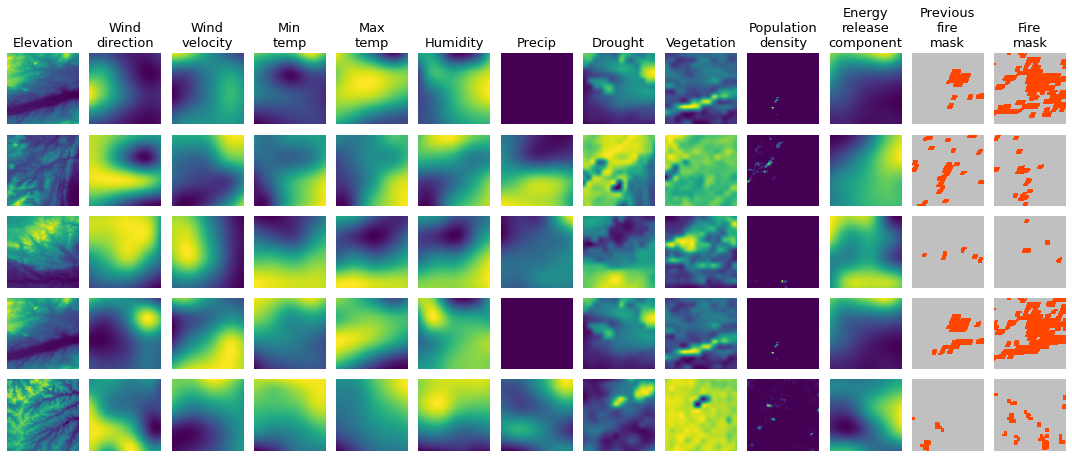

In [20]:
fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
  for j in range(n_features + 1):
    plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
    if i == 0:
      plt.title(TITLES[j], fontsize=13)
    if j < n_features - 1:
      plt.imshow(inputs[i, :, :, j], cmap='viridis')
    if j == n_features - 1:
      plt.imshow(inputs[i, :, :, -1], cmap=CMAP, norm=NORM)
    if j == n_features:
      plt.imshow(labels[i, :, :, 0], cmap=CMAP, norm=NORM) 
    plt.axis('off')
plt.tight_layout()

# Get metrics on all features

In [ ]:
samplesPos = []
samplesNeg = []
for img, lab in train_ds:
    img = lab.numpy().flatten()
    size = len(img)
    negCount = (img == 0).sum()
    posCount = size - negCount
    samplesPos.append(posCount/size)
    samplesNeg.append(negCount/size)
    
print("Mean positive class:", np.mean(samplesPos))
print("Mean positive class:", np.mean(samplesNeg))

print("Standard Deviation positive class:", np.std(samplesPos))
print("Standard Deviation positive class:", np.std(samplesNeg))


In [ ]:
def tf_welford(ds, cnt_limit=-1):
    ds_numpy = tfds.as_numpy(ds)
    w_min = np.full(12, float('inf'), dtype=np.float64)
    w_max = np.full(12, float('-inf'), dtype=np.float64)
    w_mean = np.zeros(12, dtype=np.float64)
    w_stdev = np.zeros(12, dtype=np.float64)
    sumsq = np.zeros(12, dtype=np.float64)
    

    cnt = 0.0
    for da in tqdm(ds_numpy):
        da = da[0]
        for i in range(da.shape[0]):
            cnt += 1.0
            sample = da[i]
            img_size = sample.shape[0]
            for j in range(12):
                x = sample[: , :,j]
                x = tf.reshape(x, [-1])
                
                w_min[j] = min(w_min[j], tf.reduce_min(x))
                w_max[j] = max(w_max[j], tf.reduce_max(x))
                
                delta = tf.math.reduce_mean(x - w_mean[j]).numpy()
                w_mean[j] += delta / cnt
                # variance calculation deviates a little from Welford as it uses a batch of 4096 
                sumsq[j] += tf.math.reduce_sum(tf.math.multiply(x, x)).numpy()
                w_stdev[j] = np.sqrt((sumsq[j]/(cnt*(img_size*img_size))) - w_mean[j]*w_mean[j])

            if cnt == float(cnt_limit):
                break 
        else:
            continue
        break

    return w_min, w_max, w_mean, w_stdev


CHK_COUNT = 25000

w_min, w_max, w_mean, w_stdev = tf_welford(dataset, CHK_COUNT)

In [ ]:
for i in range(12):
    print(f'Feature {i+1}:')
    print(f'Min: {w_min[i]}')# Plotting function
    print(f'Max: {w_max[i]}')
    print(f'Mean: {w_mean[i]}')
    print(f'Standard Deviation: {w_stdev[i]}')
    print()

# Train U-net model

### Clean up GPU memory

In [29]:
del unet 
K.clear_session()

### Load callbacks

In [17]:
%load_ext tensorboard

In [18]:
list_of_callbacks = []

list_of_callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                min_delta=0, 
                                patience=2, 
                                verbose=0, 
                                mode='auto', 
                                baseline=None, 
                                restore_best_weights=False))

list_of_callbacks.append(tf.keras.callbacks.ModelCheckpoint('./models/', 
                                     monitor='val_loss', 
                                     verbose=0, 
                                     save_best_only=False,
                                     save_weights_only=False, 
                                     mode='auto', 
                                     save_freq='epoch'))



log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
list_of_callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch='10, 15'))


### Custom Loss functions

In [19]:
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou


def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

def focal_loss(labels, logits, alpha, gamma=1.0):
    """Compute the focal loss between `logits` and the ground truth `labels`.
    Focal loss = -alpha_t * (1-pt)^gamma * log(pt)
    where pt is the probability of being classified to the true class.
    pt = p (if true class), otherwise pt = 1 - p. p = sigmoid(logit).
    Args:
    labels: A float32 tensor of size [batch, num_classes].
    logits: A float32 tensor of size [batch, num_classes].
    alpha: A float32 tensor of size [batch_size]
      specifying per-example weight for balanced cross entropy.
    gamma: A float32 scalar modulating loss from hard and easy examples.
    Returns:
    focal_loss: A float32 scalar representing normalized total loss.
    """
    with tf.name_scope('focal_loss'):
        logits = tf.cast(logits, dtype=tf.float32)
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=labels, logits=logits)

    # positive_label_mask = tf.equal(labels, 1.0)
    # probs = tf.sigmoid(logits)
    # probs_gt = tf.where(positive_label_mask, probs, 1.0 - probs)
    # # With gamma < 1, the implementation could produce NaN during back prop.
    # modulator = tf.pow(1.0 - probs_gt, gamma)

    # A numerically stable implementation of modulator.
    if gamma == 0.0:
      modulator = 1.0
    else:
      modulator = tf.exp(-gamma * labels * logits - gamma * tf.log1p(
          tf.exp(-1.0 * logits)))

    loss = modulator * cross_entropy

    weighted_loss = alpha * loss
    focal_loss = tf.reduce_sum(weighted_loss)
    # Normalize by the total number of positive samples.
    focal_loss /= tf.reduce_sum(labels)
    return 

### Load trained Model

In [72]:
custom_objects = {"dice_coef": dice_coef, "iou_coef": iou_coef, "accuracy": tf.keras.metrics.Accuracy(),'focal_tversky_loss': focal_tversky_loss}

unet = tf.keras.models.load_model('models-optimized/', custom_objects=custom_objects)
# unet = tf.keras.models.load_model('models/', custom_objects=custom_objects)
# unet = tf.keras.models.load_model('models-v2/', custom_objects=custom_objects)


### U-Net v1.0

In [20]:
### Load callbacksfrom keras.layers import Conv2D, BatchNormalization, Conv2DTranspose
def EncoderV1(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    conv = Conv2D(n_filters, 
                  3,  # filter size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)

    conv = Conv2D(n_filters, 
                  3,  # filter size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
  
    conv = BatchNormalization()(conv, training=False)
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv
    skip_connection = conv    
    return next_layer, skip_connection

def DecoderV1(prev_layer_input, skip_layer_input, n_filters=32):
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),
                 strides=(2,2),
                 padding='same')(prev_layer_input)
    merge = tf.concat([up, skip_layer_input], axis=3)
    conv = Conv2D(n_filters, 
                 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3, 
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv


In [21]:
def UNetV1(input_size=(64, 64, 12), n_filters=32, n_classes=1):
    """
    Combine both encoder and decoder blocks according to the U-Net research paper
    Return the model as output 
    """
    # Input size represent the size of 1 image (the size used for pre-processing) 
    inputs = Input(input_size)
    
    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
    cblock1 = EncoderV1(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderV1(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderV1(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderV1(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderV1(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    
    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderV1(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderV1(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderV1(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderV1(ublock8, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same', activation="sigmoid")(conv9)
    
    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
tic = timeit.default_timer()

epochs = 1

unet = UNetV1(n_filters=128)
unet.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[dice_coef,  tf.keras.metrics.AUC()])
results = unet.fit(train_ds, validation_data=valid_ds, epochs=epochs, callbacks=list_of_callbacks)
K.clear_session()

toc = timeit.default_timer()
print(f"Took {toc - tic} to train")


### U-Net v2.0

In [20]:
### Load callbacks

def EncoderV2(entered_input, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1

def DecoderV2(entered_input, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out

def convolution_operation(entered_input, filters=64):
    # Taking first input and implementing the first conv block
    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = LeakyReLU()(batch_norm1)
    
    # Taking first input and implementing the second conv block
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    
    dropout_layer = tf.keras.layers.Dropout(0.5)(batch_norm2)

    act2 = LeakyReLU()(dropout_layer)
    
    return act2

def UNetV2(Image_Size):
    # Take the image size and shape
    input1 = Input(Image_Size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = EncoderV2(input1, 64)
    skip2, encoder_2 = EncoderV2(encoder_1, 64*2)
    skip3, encoder_3 = EncoderV2(encoder_2, 64*4)
    skip4, encoder_4 = EncoderV2(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*16)
    
    # Construct the decoder blocks
    decoder_1 = DecoderV2(conv_block, skip4, 64*8)
    decoder_2 = DecoderV2(decoder_1, skip3, 64*4)
    decoder_3 = DecoderV2(decoder_2, skip2, 64*2)
    decoder_4 = DecoderV2(decoder_3, skip1, 64)
    
#     out = Conv2D(2, 1, padding="same", activation="sigmoid")(decoder_4)
    out = Conv2D(1, 1, padding="same", activation="sigmoid")(decoder_4)

    model = Model(input1, out)
    return model


In [21]:
input_shape = (64, 64, 12)
unet = UNetV2(input_shape)

# unet.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=['accuracy'])
unet.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[dice_coef, tf.keras.metrics.AUC()])

In [22]:
tic = timeit.default_timer()

# Train the model, doing validation at the end of each epoch.
epochs = 4
results = unet.fit(train_ds, validation_data=valid_ds, epochs=epochs, callbacks=list_of_callbacks)

K.clear_session()

toc = timeit.default_timer()
print(f"Took {toc - tic} to train")

Epoch 1/4
  46809/Unknown - 1446s 31ms/step - loss: 0.3944 - dice_coef: 0.4869 - iou_coef: 0.2246 - auc: 0.8416INFO:tensorflow:Assets written to: ./models\assets
46809/46809 [==============================] - 1503s 32ms/step - loss: 0.3944 - dice_coef: 0.4869 - iou_coef: 0.2246 - auc: 0.8416 - val_loss: 0.5536 - val_dice_coef: 0.2788 - val_iou_coef: 0.0969 - val_auc: 0.7707
Epoch 2/4
46809/46809 [==============================] - 1389s 30ms/step - loss: 0.3566 - dice_coef: 0.5168 - iou_coef: 0.2415 - auc: 0.8688 - val_loss: 0.6451 - val_dice_coef: 0.3158 - val_iou_coef: 0.1032 - val_auc: 0.7560
Epoch 3/4
46809/46809 [==============================] - 1495s 32ms/step - loss: 0.3426 - dice_coef: 0.5321 - iou_coef: 0.2514 - auc: 0.8792 - val_loss: 0.5766 - val_dice_coef: 0.3857 - val_iou_coef: 0.1344 - val_auc: 0.7683
Took 4387.9931816 to train


### U-Net v3.0

In [24]:
def EncoderV3(inputs, n_filters=32, dropout_prob=0.3, activation='relu', init='he_normal', max_pooling=True):
    conv = Conv2D(n_filters, 
                  3,  # filter size
                  activation=activation,
                  padding='same',
                  kernel_initializer=init)(inputs)

    conv = Conv2D(n_filters, 
                  3,  # filter size
                  activation=activation,
                  padding='same',
                  kernel_initializer=init)(conv)
  
    conv = BatchNormalization()(conv, training=False)
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv
    skip_connection = conv    
    return next_layer, skip_connection

def DecoderV3(prev_layer_input, skip_layer_input, n_filters=32, activation='relu', init='HeNormal',):
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),
                 strides=(2,2),
                 padding='same')(prev_layer_input)
    merge = tf.concat([up, skip_layer_input], axis=3)
    conv = Conv2D(n_filters, 
                 3,  
                 activation=activation,
                 padding='same',
                 kernel_initializer=init)(merge)
    conv = Conv2D(n_filters,
                 3, 
                 activation=activation,
                 padding='same',
                 kernel_initializer=init)(conv)
    return conv


In [25]:
def UNetV3(input_size=(64, 64, 12), n_filters=32, drop_out_prob=0.3, n_classes=1, n_layers=3, init='he_normal', activation='relu'):
    """
    Combine both encoder and decoder blocks according to the U-Net research paper
    Return the model as output 
    """
    # Input size represent the size of 1 image (the size used for pre-processing) 
    inputs = Input(input_size)
    
    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
    
    encodeBlocks = []
    
    cblock = EncoderV3(inputs, n_filters, dropout_prob=0, max_pooling=True, init=init, activation=activation)
    encodeBlocks.append(cblock)
    multiplier = 2
    for i in range(n_layers):
        cblock = EncoderV3(encodeBlocks[-1][0], n_filters*multiplier,dropout_prob=drop_out_prob, max_pooling=True, init=init, activation=activation)
        encodeBlocks.append(cblock) 
        multiplier *= 2

    cblock = EncoderV3(encodeBlocks[-1][0],n_filters*multiplier,dropout_prob=drop_out_prob, max_pooling=False, init=init, activation=activation)
    encodeBlocks.append(cblock) 
    multiplier /= 2

    decodeBlocks = []
    ublock = DecoderV3(encodeBlocks.pop()[0], encodeBlocks.pop()[1],  n_filters * multiplier, init=init, activation=activation)
    decodeBlocks.append(ublock)
    multiplier /= 2

    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    for i in range(n_layers):
        ublock = DecoderV3(decodeBlocks[-1], encodeBlocks.pop()[1],  n_filters * multiplier, init=init, activation=activation)
        decodeBlocks.append(ublock) 
        multiplier /= 2

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Observe the number of channels will be equal to number of output classes
    conv = Conv2D(n_filters,
                 3,
                 activation=activation,
                 padding='same',
                 kernel_initializer=init)(decodeBlocks[-1])

    outputLayer = Conv2D(n_classes, 1, padding='same', activation="sigmoid")(conv)
    
    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=outputLayer)

    return model

In [34]:
unet = UNetV3(n_filters=161, drop_out_prob=0.475,
                       n_layers=3, init='he_normal', activation='selu')

unet.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-07), loss=tf.keras.losses.BinaryCrossentropy(),  metrics=[dice_coef, tf.keras.metrics.AUC()])
tic = timeit.default_timer()

# Train the model, doing validation at the end of each epoch.
epochs = 3
results = unet.fit(train_ds, validation_data=valid_ds, epochs=epochs, callbacks=list_of_callbacks)

K.clear_session()

toc = timeit.default_timer()
print(f"Took {toc - tic} to train")

Epoch 1/3
  46809/Unknown - 4837s 103ms/step - loss: 0.4114 - dice_coef: 0.4467 - iou_coef: 0.1990 - accuracy: 6.0654e-06 - auc: 0.8208INFO:tensorflow:Assets written to: ./models\assets
46809/46809 [==============================] - 4990s 106ms/step - loss: 0.4114 - dice_coef: 0.4467 - iou_coef: 0.1990 - accuracy: 6.0654e-06 - auc: 0.8208 - val_loss: 0.5227 - val_dice_coef: 0.4821 - val_iou_coef: 0.1886 - val_accuracy: 0.0045 - val_auc: 0.7884
Epoch 2/3
46809/46809 [==============================] - 5027s 107ms/step - loss: 0.4026 - dice_coef: 0.4541 - iou_coef: 0.2028 - accuracy: 7.8872e-06 - auc: 0.8290 - val_loss: 0.5538 - val_dice_coef: 0.4844 - val_iou_coef: 0.1897 - val_accuracy: 0.0070 - val_auc: 0.7844
Epoch 3/3
46809/46809 [==============================] - 5088s 109ms/step - loss: 0.3966 - dice_coef: 0.4598 - iou_coef: 0.2057 - accuracy: 1.1171e-05 - auc: 0.8346 - val_loss: 0.5849 - val_dice_coef: 0.4843 - val_iou_coef: 0.1898 - val_accuracy: 0.0101 - val_auc: 0.7794
Took 151

### U-Net v4.0

* Add dropout layers
* Make programatic architecture
* Increase model size
* Maybe try to previous upsampling and downsampling layers instead of inception

In [20]:
alpha = 0.1

def conv2d_block(input_tensor,
                 n_filters,
                 kernel_size=3,
                 batchnorm=True,
                 strides=1,
                 dilation_rate=1,
                 recurrent=1):

    # A wrapper of the Keras Conv2D block to serve as a building block for downsampling layers
    # Includes options to use batch normalization, dilation and recurrence

    conv = Conv2D(filters=n_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  kernel_initializer="he_normal",
                  padding="same",
                  dilation_rate=dilation_rate)(input_tensor)
    if batchnorm:
        conv = BatchNormalization()(conv)
    output = LeakyReLU(alpha=alpha)(conv)

    for _ in range(recurrent - 1):
        conv = Conv2D(filters=n_filters,
                      kernel_size=kernel_size,
                      strides=1,
                      kernel_initializer="he_normal",
                      padding="same",
                      dilation_rate=dilation_rate)(output)
        if batchnorm:
            conv = BatchNormalization()(conv)
        res = LeakyReLU(alpha=alpha)(conv)
        output = Add()([output, res])

    return output
    

def inception_block(input_tensor,
                    n_filters,
                    kernel_size=3,
                    strides=1,
                    batchnorm=True,
                    recurrent=1,
                    layers=[]):

    # Inception-style convolutional block similar to InceptionNet
    # The first convolution follows the function arguments, while subsequent inception convolutions follow the parameters in
    # argument, layers

    # layers is a nested list containing the different secondary inceptions in the format of (kernel_size, dil_rate)

    # E.g => layers=[ [(3,1),(3,1)], [(5,1)], [(3,1),(3,2)] ]
    # This will implement 3 sets of secondary convolutions
    # Set 1 => 3x3 dil = 1 followed by another 3x3 dil = 1
    # Set 2 => 5x5 dil = 1
    # Set 3 => 3x3 dil = 1 followed by 3x3 dil = 2

    res = conv2d_block(input_tensor,
                       n_filters=n_filters,
                       kernel_size=kernel_size,
                       strides=strides,
                       batchnorm=batchnorm,
                       dilation_rate=1,
                       recurrent=recurrent)

    temp = []
    for layer in layers:
        local_res = res
        for conv in layer:
            incep_kernel_size = conv[0]
            incep_dilation_rate = conv[1]
            local_res = conv2d_block(local_res,
                                     n_filters=n_filters,
                                     kernel_size=incep_kernel_size,
                                     strides=1,
                                     batchnorm=batchnorm,
                                     dilation_rate=incep_dilation_rate,
                                     recurrent=recurrent)
        temp.append(local_res)

    temp = concatenate(temp)
    res = conv2d_block(temp,
                       n_filters=n_filters,
                       kernel_size=1,
                       strides=1,
                       batchnorm=batchnorm,
                       dilation_rate=1)

    shortcut = conv2d_block(input_tensor,
                            n_filters=n_filters,
                            kernel_size=1,
                            strides=strides,
                            batchnorm=batchnorm,
                            dilation_rate=1)
    if batchnorm:
        shortcut = BatchNormalization()(shortcut)

    output = Add()([shortcut, res])
    return output


def transpose_block(input_tensor,
                    skip_tensor,
                    n_filters,
                    kernel_size=3,
                    strides=1,
                    batchnorm=True,
                    recurrent=1):

    # A wrapper of the Keras Conv2DTranspose block to serve as a building block for upsampling layers

    shape_x = K.int_shape(input_tensor)
    shape_xskip = K.int_shape(skip_tensor)

    conv = Conv2DTranspose(filters=n_filters,
                           kernel_size=kernel_size,
                           padding='same',
                           strides=(shape_xskip[1] // shape_x[1],
                                    shape_xskip[2] // shape_x[2]),
                           kernel_initializer="he_normal")(input_tensor)
    conv = LeakyReLU(alpha=alpha)(conv)

    act = conv2d_block(conv,
                       n_filters=n_filters,
                       kernel_size=kernel_size,
                       strides=1,
                       batchnorm=batchnorm,
                       dilation_rate=1,
                       recurrent=recurrent)
    output = Concatenate(axis=3)([act, skip_tensor])
    return output


def expend_as(tensor, rep):

    # Anonymous lambda function to expand the specified axis by a factor of argument, rep.
    # If tensor has shape (512,512,N), lambda will return a tensor of shape (512,512,N*rep), if specified axis=2

    my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                       arguments={'repnum': rep})(tensor)
    return my_repeat


def AttnGatingBlock(x, g, inter_shape):

    shape_x = K.int_shape(x)
    shape_g = K.int_shape(g)
    

    # Getting the gating signal to the same number of filters as the inter_shape
    phi_g = Conv2D(filters=inter_shape,
                   kernel_size=1,
                   strides=1,
                   padding='same')(g)

    # Getting the x signal to the same shape as the gating signal
    theta_x = Conv2D(filters=inter_shape,
                     kernel_size=3,
                     strides=(shape_x[1] // shape_g[1],
                              shape_x[2] // shape_g[2]),
                     padding='same')(x)

    # Element-wise addition of the gating and x signals
    add_xg = Add()([phi_g, theta_x])
    add_xg = Activation('relu')(add_xg)

    # 1x1x1 convolution
    psi = Conv2D(filters=1, kernel_size=1, padding='same')(add_xg)
    psi = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(psi)

    # Upsampling psi back to the original dimensions of x signal
    upsample_sigmoid_xg = UpSampling2D(
        size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(psi)

    # Expanding the filter axis to the number of filters in the original x signal
    upsample_sigmoid_xg = expend_as(upsample_sigmoid_xg, shape_x[3])

    # Element-wise multiplication of attention coefficients back onto original x signal
    attn_coefficients = multiply([upsample_sigmoid_xg, x])

    # Final 1x1x1 convolution to consolidate attention signal to original x dimensions
    
    output = Conv2D(filters=shape_x[3],
                    kernel_size=1,
                    strides=1,
                    padding='same')(attn_coefficients)
    output = BatchNormalization()(output)
    return output

In [21]:
def network(input_img, n_filters=16, batchnorm=True):

    # contracting path

    c0 = inception_block(input_img,
                         n_filters=n_filters,
                         batchnorm=batchnorm,
                         strides=1,
                         recurrent=2,
                         layers=[[(3, 1), (3, 1)], [(3, 2)]])  # 512x512x512

    c1 = inception_block(c0,
                         n_filters=n_filters * 2,
                         batchnorm=batchnorm,
                         strides=2,
                         recurrent=2,
                         layers=[[(3, 1), (3, 1)], [(3, 2)]])  # 256x256x256

    c2 = inception_block(c1,
                         n_filters=n_filters * 4,
                         batchnorm=batchnorm,
                         strides=2,
                         recurrent=2,
                         layers=[[(3, 1), (3, 1)], [(3, 2)]])  # 128x128x128

    c3 = inception_block(c2,
                         n_filters=n_filters * 8,
                         batchnorm=batchnorm,
                         strides=2,
                         recurrent=2,
                         layers=[[(3, 1), (3, 1)], [(3, 2)]])  # 64x64x64

    # bridge

    b0 = inception_block(c3,
                         n_filters=n_filters * 16,
                         batchnorm=batchnorm,
                         strides=2,
                         recurrent=2,
                         layers=[[(3, 1), (3, 1)], [(3, 2)]])  # 32x32x32

    # expansive path

    attn0 = AttnGatingBlock(c3, b0, n_filters * 16)
    u0 = transpose_block(b0,
                         attn0,
                         n_filters=n_filters * 8,
                         batchnorm=batchnorm,
                         recurrent=2)  # 64x64x64

    attn1 = AttnGatingBlock(c2, u0, n_filters * 8)
    u1 = transpose_block(u0,
                         attn1,
                         n_filters=n_filters * 4,
                         batchnorm=batchnorm,
                         recurrent=2)  # 128x128x128

    attn2 = AttnGatingBlock(c1, u1, n_filters * 4)
    u2 = transpose_block(u1,
                         attn2,
                         n_filters=n_filters * 2,
                         batchnorm=batchnorm,
                         recurrent=2)  # 256x256x256

    u3 = transpose_block(u2,
                         c0,
                         n_filters=n_filters,
                         batchnorm=batchnorm,
                         recurrent=2)  # 512x512x512

    outputs = Conv2D(filters=1, kernel_size=1, strides=1,
                     activation='sigmoid')(u3)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [26]:
def UNetV4(input_size=(64, 64, 12), n_filters=32, batchnorm=True, drop_out_prob=0.3, n_classes=1, n_layers=3, init='he_normal', activation='relu'):
    """
    Combine both encoder and decoder blocks according to the U-Net research paper
    Return the model as output 
    """
    # Input size represent the size of 1 image (the size used for pre-processing) 
    inputs = Input(input_size)
    
    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
    
    encodeBlocks = []
    
    cblock = inception_block(inputs,
                         n_filters=n_filters,
                         batchnorm=batchnorm,
                         strides=1,
                         recurrent=2,
                         layers=[[(3, 1), (3, 1)], [(3, 2)]])
    encodeBlocks.append(cblock)
    multiplier = 2
    for i in range(n_layers):
        cblock =  inception_block(encodeBlocks[-1],
                         n_filters=n_filters * multiplier,
                         batchnorm=batchnorm,
                         strides=2,
                         recurrent=2,
                         layers=[[(3, 1), (3, 1)], [(3, 2)]])
        encodeBlocks.append(cblock) 
        multiplier *= 2

    bblock = inception_block(encodeBlocks[-1],
                         n_filters=n_filters * multiplier,
                         batchnorm=batchnorm,
                         strides=2,
                         recurrent=2,
                         layers=[[(3, 1), (3, 1)], [(3, 2)]])
                                 

    decodeBlocks = []
    attentionBlocks = []
    ablock = AttnGatingBlock(encodeBlocks.pop(), bblock, n_filters * multiplier)

    multiplier /= 2
                                 
    ublock = transpose_block(bblock,
                         ablock,
                         n_filters=n_filters * multiplier,
                         batchnorm=batchnorm,
                         recurrent=2)  # 64x64x64

    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    for i in range(n_layers):
        if i == n_layers-1:
            multiplier /= 2
            ublock = transpose_block(ublock,
                             encodeBlocks.pop(),
                             n_filters=n_filters * multiplier,
                             batchnorm=batchnorm,
                             recurrent=2)
        else: 
            ablock = AttnGatingBlock(encodeBlocks.pop(), ublock, n_filters * multiplier)

            multiplier /= 2

            ublock = transpose_block(ublock,
                                 ablock,
                                 n_filters=n_filters * multiplier,
                                 batchnorm=batchnorm,
                                 recurrent=2)  # 64x64x64

                                 
    outputs = Conv2D(filters=1, kernel_size=1, strides=1, padding='same',
                     activation='sigmoid')(ublock)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [23]:
alpha = 0.1

input_shape = (64, 64, 12)
inputs = Input(input_shape)
 
# unet = network(inputs)
unet = UNetV4(n_filters=18, n_layers=2, 'selu')

unet.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=8.3e-04), loss=tf.keras.losses.BinaryCrossentropy(),  metrics=[dice_coef, tf.keras.metrics.AUC()])
tic = timeit.default_timer()

# Train the model, doing validation at the end of each epoch.
epochs = 5
results = unet.fit(train_ds, validation_data=valid_ds, epochs=epochs, callbacks=list_of_callbacks)

K.clear_session()

toc = timeit.default_timer()
print(f"Took {toc - tic} to train")

Epoch 1/5
  46809/Unknown - 2805s 60ms/step - loss: 0.2929 - dice_coef: 0.6072 - auc: 0.9131INFO:tensorflow:Assets written to: ./models\assets
46809/46809 [==============================] - 2900s 62ms/step - loss: 0.2929 - dice_coef: 0.6072 - auc: 0.9131 - val_loss: 0.6397 - val_dice_coef: 0.4610 - val_auc: 0.7591
Epoch 2/5
46809/46809 [==============================] - 3005s 64ms/step - loss: 0.2454 - dice_coef: 0.6698 - auc: 0.9406 - val_loss: 0.6134 - val_dice_coef: 0.4748 - val_auc: 0.7702
Epoch 3/5
46809/46809 [==============================] - 2922s 62ms/step - loss: 0.2193 - dice_coef: 0.7059 - auc: 0.9531 - val_loss: 0.6412 - val_dice_coef: 0.4762 - val_auc: 0.7681
Epoch 4/5
46809/46809 [==============================] - 2870s 61ms/step - loss: 0.2031 - dice_coef: 0.7283 - auc: 0.9598 - val_loss: 0.6616 - val_dice_coef: 0.4869 - val_auc: 0.7724
Took 11697.2824037 to train


### U-Net v5.0

In [22]:
def EncoderV5(inputs, n_filters=32, dropout_prob=0.3, activation='relu', init='he_normal', max_pooling=True):
    conv = Conv2D(n_filters, 
                  3,  # filter size
                  activation=activation,
                  padding='same',
                  kernel_initializer=init)(inputs)

    conv = Conv2D(n_filters, 
                  3,  # filter size
                  activation=activation,
                  padding='same',
                  kernel_initializer=init)(conv)
  
    conv = BatchNormalization()(conv, training=False)
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv
    skip_connection = conv    
    return next_layer, skip_connection

def DecoderV5(prev_layer_input, skip_layer_input, n_filters=32, activation='relu', init='HeNormal',):
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),
                 strides=(2,2),
                 padding='same')(prev_layer_input)
    merge = tf.concat([up, skip_layer_input], axis=3)
    conv = Conv2D(n_filters, 
                 3,  
                 activation=activation,
                 padding='same',
                 kernel_initializer=init)(merge)
    conv = Conv2D(n_filters,
                 3, 
                 activation=activation,
                 padding='same',
                 kernel_initializer=init)(conv)
    return conv


In [23]:
def UNetV5(input_size=(64, 64, 12), n_filters=32, drop_out_prob=0.3, n_classes=1, n_layers=3, init='he_normal', activation='relu'):
    """
    Combine both encoder and decoder blocks according to the U-Net research paper
    Return the model as output 
    """
    # Input size represent the size of 1 image (the size used for pre-processing) 
    inputs = Input(input_size)
    
    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
    
    encodeBlocks = []
    
    cblock = EncoderV5(inputs, n_filters, dropout_prob=0, max_pooling=True, init=init, activation=activation)
    encodeBlocks.append(cblock)
    multiplier = 2
    for i in range(n_layers):
        cblock = EncoderV5(encodeBlocks[-1][0], n_filters*multiplier,dropout_prob=drop_out_prob, max_pooling=True, init=init, activation=activation)
        encodeBlocks.append(cblock) 
        multiplier *= 2

    cblock = EncoderV5(encodeBlocks[-1][0],n_filters*multiplier,dropout_prob=drop_out_prob, max_pooling=False, init=init, activation=activation)

    ablock = AttnGatingBlock(encodeBlocks.pop()[1], cblock[0], n_filters * multiplier)
    
    multiplier /= 2
    
    ublock = DecoderV5(cblock[0], ablock,  n_filters * multiplier, init=init, activation=activation)

    
    for i in range(n_layers):
        if i == n_layers-1:
            multiplier /= 2
            ublock = DecoderV5(ublock, encodeBlocks.pop()[1],  n_filters * multiplier, init=init, activation=activation)

        else: 
            ablock = AttnGatingBlock(encodeBlocks.pop()[1], ublock, n_filters * multiplier)

            multiplier /= 2

            ublock = DecoderV5(ublock, ablock,  n_filters * multiplier, init=init, activation=activation)
            


        
        
    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Observe the number of channels will be equal to number of output classes
    conv = Conv2D(n_filters,
                 3,
                 activation=activation,
                 padding='same',
                 kernel_initializer=init)(ublock)

    outputLayer = Conv2D(n_classes, 1, padding='same', activation="sigmoid")(conv)
    
    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=outputLayer)

    return model



In [31]:
alpha = 0.1

input_shape = (64, 64, 12)
inputs = Input(input_shape)
 
# unet = network(inputs)
unet = UNetV5(n_filters=64, n_layers=2, drop_out_prob=0.47,  activation='selu')

unet.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.000001), loss=tf.keras.losses.BinaryCrossentropy(),  metrics=[dice_coef, tf.keras.metrics.AUC()])
tic = timeit.default_timer()

# Train the model, doing validation at the end of each epoch.
epochs = 4
results = unet.fit(train_ds, validation_data=valid_ds, epochs=epochs, callbacks=list_of_callbacks)

K.clear_session()

toc = timeit.default_timer()
print(f"Took {toc - tic} to train")

Epoch 1/4
  46809/Unknown - 1403s 30ms/step - loss: 0.4312 - dice_coef: 0.4256 - iou_coef: 0.1860 - auc: 0.8015INFO:tensorflow:Assets written to: ./models\assets
46809/46809 [==============================] - 1458s 31ms/step - loss: 0.4312 - dice_coef: 0.4256 - iou_coef: 0.1860 - auc: 0.8015 - val_loss: 0.6286 - val_dice_coef: 0.4672 - val_iou_coef: 0.1948 - val_auc: 0.7770
Epoch 2/4
46809/46809 [==============================] - 1405s 30ms/step - loss: 0.3943 - dice_coef: 0.4532 - iou_coef: 0.1997 - auc: 0.8354 - val_loss: 0.5999 - val_dice_coef: 0.4684 - val_iou_coef: 0.1962 - val_auc: 0.7802
Epoch 3/4
46809/46809 [==============================] - 1492s 32ms/step - loss: 0.3848 - dice_coef: 0.4644 - iou_coef: 0.2063 - auc: 0.8445 - val_loss: 0.6112 - val_dice_coef: 0.4667 - val_iou_coef: 0.1977 - val_auc: 0.7763
Epoch 4/4
46809/46809 [==============================] - 1507s 32ms/step - loss: 0.3785 - dice_coef: 0.4726 - iou_coef: 0.2111 - auc: 0.8502 - val_loss: 0.6114 - val_dice_co

### Test Model on training set

In [34]:
a_iter = iter(train_ds)
inp1, lab1 = next(a_iter)
dataset = tf.data.Dataset.from_tensors((inp1, lab1))
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

b_iter = iter(valid_ds)
inp2, lab2 = next(b_iter)
val_dataset = tf.data.Dataset.from_tensors((inp2, lab2))
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [41]:
epochs = 1000
# unet = UNetV5(n_filters=140, n_layers=3, drop_out_prob=0.47)
unet = UNetV3(n_filters=160, n_layers=3, drop_out_prob=0.47)
# unet = UNetV1()

# unet.compile(optimizer=tf.keras.optimizers.Adam(beta_1=0.99, learning_rate=0.00001), loss=tversky_loss, metrics=[dice_coef,iou_coef])
# unet = U_Net(input_shape)
# unet.compile(optimizer=tf.keras.optimizers.RMSprop(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[dice_coef])
unet.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0000001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[dice_coef, tf.keras.metrics.AUC()])

hist = unet.fit(dataset, epochs=epochs)
metrics = unet.evaluate(dataset)
print(metrics)

K.clear_session()


Epoch 1/1000
1/1 [==============================] - 32s 32s/step - loss: 1.1719 - dice_coef: 0.2716 - iou_coef: 0.1452 - auc: 0.5784
Epoch 2/1000
1/1 [==============================] - 0s 438ms/step - loss: 1.1641 - dice_coef: 0.2714 - iou_coef: 0.1449 - auc: 0.5777
Epoch 3/1000
1/1 [==============================] - 0s 443ms/step - loss: 1.1592 - dice_coef: 0.2713 - iou_coef: 0.1448 - auc: 0.5775
Epoch 4/1000
1/1 [==============================] - 0s 438ms/step - loss: 1.1553 - dice_coef: 0.2712 - iou_coef: 0.1446 - auc: 0.5765
Epoch 5/1000
1/1 [==============================] - 0s 436ms/step - loss: 1.1504 - dice_coef: 0.2711 - iou_coef: 0.1445 - auc: 0.5767
Epoch 6/1000
1/1 [==============================] - 0s 439ms/step - loss: 1.1465 - dice_coef: 0.2710 - iou_coef: 0.1444 - auc: 0.5766
Epoch 7/1000
1/1 [==============================] - 0s 437ms/step - loss: 1.1436 - dice_coef: 0.2711 - iou_coef: 0.1444 - auc: 0.5774
Epoch 8/1000
1/1 [==============================] - 0s 437ms/st

1/1 [==============================] - 0s 441ms/step - loss: 0.9180 - dice_coef: 0.2650 - iou_coef: 0.1367 - auc: 0.5694
Epoch 122/1000
1/1 [==============================] - 0s 439ms/step - loss: 0.9160 - dice_coef: 0.2648 - iou_coef: 0.1365 - auc: 0.5682
Epoch 123/1000
1/1 [==============================] - 0s 442ms/step - loss: 0.9150 - dice_coef: 0.2646 - iou_coef: 0.1363 - auc: 0.5675
Epoch 124/1000
1/1 [==============================] - 0s 440ms/step - loss: 0.9136 - dice_coef: 0.2647 - iou_coef: 0.1364 - auc: 0.5683
Epoch 125/1000
1/1 [==============================] - 0s 439ms/step - loss: 0.9106 - dice_coef: 0.2646 - iou_coef: 0.1362 - auc: 0.5681
Epoch 126/1000
1/1 [==============================] - 0s 443ms/step - loss: 0.9097 - dice_coef: 0.2646 - iou_coef: 0.1362 - auc: 0.5686
Epoch 127/1000
1/1 [==============================] - 0s 440ms/step - loss: 0.9077 - dice_coef: 0.2645 - iou_coef: 0.1361 - auc: 0.5688
Epoch 128/1000
1/1 [==============================] - 0s 441ms/

1/1 [==============================] - 0s 440ms/step - loss: 0.7432 - dice_coef: 0.2509 - iou_coef: 0.1241 - auc: 0.5402
Epoch 242/1000
1/1 [==============================] - 0s 442ms/step - loss: 0.7417 - dice_coef: 0.2511 - iou_coef: 0.1242 - auc: 0.5417
Epoch 243/1000
1/1 [==============================] - 0s 441ms/step - loss: 0.7407 - dice_coef: 0.2507 - iou_coef: 0.1239 - auc: 0.5403
Epoch 244/1000
1/1 [==============================] - 0s 440ms/step - loss: 0.7397 - dice_coef: 0.2505 - iou_coef: 0.1238 - auc: 0.5398
Epoch 245/1000
1/1 [==============================] - 0s 441ms/step - loss: 0.7383 - dice_coef: 0.2506 - iou_coef: 0.1238 - auc: 0.5406
Epoch 246/1000
1/1 [==============================] - 0s 439ms/step - loss: 0.7363 - dice_coef: 0.2503 - iou_coef: 0.1236 - auc: 0.5397
Epoch 247/1000
1/1 [==============================] - 0s 441ms/step - loss: 0.7358 - dice_coef: 0.2501 - iou_coef: 0.1234 - auc: 0.5389
Epoch 248/1000
1/1 [==============================] - 0s 440ms/

1/1 [==============================] - 0s 440ms/step - loss: 0.6221 - dice_coef: 0.2271 - iou_coef: 0.1069 - auc: 0.4984
Epoch 362/1000
1/1 [==============================] - 0s 440ms/step - loss: 0.6211 - dice_coef: 0.2274 - iou_coef: 0.1070 - auc: 0.5005
Epoch 363/1000
1/1 [==============================] - 0s 439ms/step - loss: 0.6201 - dice_coef: 0.2274 - iou_coef: 0.1069 - auc: 0.5010
Epoch 364/1000
1/1 [==============================] - 0s 439ms/step - loss: 0.6196 - dice_coef: 0.2265 - iou_coef: 0.1065 - auc: 0.4980
Epoch 365/1000
1/1 [==============================] - 0s 440ms/step - loss: 0.6187 - dice_coef: 0.2269 - iou_coef: 0.1066 - auc: 0.4999
Epoch 366/1000
1/1 [==============================] - 0s 439ms/step - loss: 0.6187 - dice_coef: 0.2262 - iou_coef: 0.1063 - auc: 0.4979
Epoch 367/1000
1/1 [==============================] - 0s 440ms/step - loss: 0.6172 - dice_coef: 0.2260 - iou_coef: 0.1061 - auc: 0.4979
Epoch 368/1000
1/1 [==============================] - 0s 439ms/

1/1 [==============================] - 0s 439ms/step - loss: 0.5571 - dice_coef: 0.2052 - iou_coef: 0.0918 - auc: 0.4808
Epoch 482/1000
1/1 [==============================] - 0s 441ms/step - loss: 0.5581 - dice_coef: 0.2046 - iou_coef: 0.0916 - auc: 0.4792
Epoch 483/1000
1/1 [==============================] - 0s 439ms/step - loss: 0.5571 - dice_coef: 0.2046 - iou_coef: 0.0915 - auc: 0.4796
Epoch 484/1000
1/1 [==============================] - 0s 439ms/step - loss: 0.5557 - dice_coef: 0.2051 - iou_coef: 0.0917 - auc: 0.4815
Epoch 485/1000
1/1 [==============================] - 0s 441ms/step - loss: 0.5562 - dice_coef: 0.2046 - iou_coef: 0.0914 - auc: 0.4801
Epoch 486/1000
1/1 [==============================] - 0s 440ms/step - loss: 0.5557 - dice_coef: 0.2046 - iou_coef: 0.0915 - auc: 0.4809
Epoch 487/1000
1/1 [==============================] - 0s 443ms/step - loss: 0.5557 - dice_coef: 0.2044 - iou_coef: 0.0913 - auc: 0.4802
Epoch 488/1000
1/1 [==============================] - 0s 439ms/

1/1 [==============================] - 0s 438ms/step - loss: 0.5210 - dice_coef: 0.1997 - iou_coef: 0.0861 - auc: 0.4971
Epoch 602/1000
1/1 [==============================] - 0s 442ms/step - loss: 0.5220 - dice_coef: 0.1994 - iou_coef: 0.0860 - auc: 0.4962
Epoch 603/1000
1/1 [==============================] - 0s 436ms/step - loss: 0.5210 - dice_coef: 0.1997 - iou_coef: 0.0861 - auc: 0.4980
Epoch 604/1000
1/1 [==============================] - 0s 440ms/step - loss: 0.5210 - dice_coef: 0.1991 - iou_coef: 0.0859 - auc: 0.4962
Epoch 605/1000
1/1 [==============================] - 0s 441ms/step - loss: 0.5210 - dice_coef: 0.1995 - iou_coef: 0.0859 - auc: 0.4974
Epoch 606/1000
1/1 [==============================] - 0s 441ms/step - loss: 0.5195 - dice_coef: 0.2000 - iou_coef: 0.0861 - auc: 0.4992
Epoch 607/1000
1/1 [==============================] - 0s 440ms/step - loss: 0.5205 - dice_coef: 0.1996 - iou_coef: 0.0860 - auc: 0.4981
Epoch 608/1000
1/1 [==============================] - 0s 443ms/

1/1 [==============================] - 0s 439ms/step - loss: 0.4954 - dice_coef: 0.2039 - iou_coef: 0.0853 - auc: 0.5291
Epoch 722/1000
1/1 [==============================] - 0s 441ms/step - loss: 0.4949 - dice_coef: 0.2040 - iou_coef: 0.0853 - auc: 0.5301
Epoch 723/1000
1/1 [==============================] - 0s 440ms/step - loss: 0.4949 - dice_coef: 0.2041 - iou_coef: 0.0853 - auc: 0.5301
Epoch 724/1000
1/1 [==============================] - 0s 440ms/step - loss: 0.4946 - dice_coef: 0.2039 - iou_coef: 0.0853 - auc: 0.5303
Epoch 725/1000
1/1 [==============================] - 0s 440ms/step - loss: 0.4944 - dice_coef: 0.2039 - iou_coef: 0.0852 - auc: 0.5301
Epoch 726/1000
1/1 [==============================] - 0s 443ms/step - loss: 0.4941 - dice_coef: 0.2042 - iou_coef: 0.0852 - auc: 0.5310
Epoch 727/1000
1/1 [==============================] - 0s 440ms/step - loss: 0.4934 - dice_coef: 0.2046 - iou_coef: 0.0855 - auc: 0.5326
Epoch 728/1000
1/1 [==============================] - 0s 438ms/

1/1 [==============================] - 0s 440ms/step - loss: 0.4739 - dice_coef: 0.2116 - iou_coef: 0.0857 - auc: 0.5641
Epoch 842/1000
1/1 [==============================] - 0s 438ms/step - loss: 0.4731 - dice_coef: 0.2119 - iou_coef: 0.0859 - auc: 0.5658
Epoch 843/1000
1/1 [==============================] - 0s 440ms/step - loss: 0.4734 - dice_coef: 0.2114 - iou_coef: 0.0857 - auc: 0.5650
Epoch 844/1000
1/1 [==============================] - 0s 438ms/step - loss: 0.4734 - dice_coef: 0.2117 - iou_coef: 0.0857 - auc: 0.5653
Epoch 845/1000
1/1 [==============================] - 0s 440ms/step - loss: 0.4729 - dice_coef: 0.2120 - iou_coef: 0.0859 - auc: 0.5661
Epoch 846/1000
1/1 [==============================] - 0s 439ms/step - loss: 0.4734 - dice_coef: 0.2113 - iou_coef: 0.0856 - auc: 0.5646
Epoch 847/1000
1/1 [==============================] - 0s 437ms/step - loss: 0.4727 - dice_coef: 0.2121 - iou_coef: 0.0858 - auc: 0.5667
Epoch 848/1000
1/1 [==============================] - 0s 440ms/

1/1 [==============================] - 0s 438ms/step - loss: 0.4565 - dice_coef: 0.2206 - iou_coef: 0.0865 - auc: 0.5945
Epoch 962/1000
1/1 [==============================] - 0s 442ms/step - loss: 0.4568 - dice_coef: 0.2200 - iou_coef: 0.0863 - auc: 0.5940
Epoch 963/1000
1/1 [==============================] - 0s 439ms/step - loss: 0.4565 - dice_coef: 0.2203 - iou_coef: 0.0864 - auc: 0.5946
Epoch 964/1000
1/1 [==============================] - 0s 439ms/step - loss: 0.4561 - dice_coef: 0.2207 - iou_coef: 0.0865 - auc: 0.5952
Epoch 965/1000
1/1 [==============================] - 0s 436ms/step - loss: 0.4558 - dice_coef: 0.2210 - iou_coef: 0.0866 - auc: 0.5963
Epoch 966/1000
1/1 [==============================] - 0s 438ms/step - loss: 0.4558 - dice_coef: 0.2205 - iou_coef: 0.0866 - auc: 0.5959
Epoch 967/1000
1/1 [==============================] - 0s 439ms/step - loss: 0.4561 - dice_coef: 0.2210 - iou_coef: 0.0866 - auc: 0.5958
Epoch 968/1000
1/1 [==============================] - 0s 439ms/

In [32]:
i = 0
probPred = unet.predict(inp1).astype("float32")
preds = (probPred > 0.5).astype("float32")
    

fig = plt.figure(figsize=(15,15))

TITLES = ['Prev fire map', 'Label fire map', 'Predicted Fire Map']
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
n_rows = 9
for i in range(n_rows):
  for j in range(len(TITLES)):
    plt.subplot(n_rows, 3 + 1, i * (3 + 1) + j + 1)
    if i == 0:
      plt.title(TITLES[j], fontsize=13)
    if j == 0 :
      plt.imshow(inp1[i, :, :, -1], cmap=CMAP, norm=NORM)
    if j == 1:
      plt.imshow(lab1[i, :, :], cmap=CMAP, norm=NORM)
    if j == 2:
      plt.imshow(preds[i, :, :], cmap=CMAP, norm=NORM) 
    plt.axis('off')
plt.tight_layout()

NameError: name 'inp1' is not defined

### Tensorboard

In [18]:
%tensorboard --logdir=C:/Users/kamen/OneDrive/Documents/shared_drive/Thesis/Wildfire_Data_Generator/logs/fit  --port=6006  --host localhost

### Bayesian Hyperparamater Tuning

In [46]:
a_iter = iter(train_ds)
inp, lab = next(a_iter)
dataset = tf.data.Dataset.from_tensors((inp, lab))
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

b_iter = iter(valid_ds)
inp, lab = next(b_iter)
val_dataset = tf.data.Dataset.from_tensors((inp, lab))
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
epochs = 4
dim_learning_rate = Real(low=1e-7, high=1e-3, prior='log-uniform',
                         name='learning_rate')
dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')
dim_num_dense_nodes = Integer(low=16, high=256, name='num_dense_nodes')
dim_activation = Categorical(categories=['relu', 'selu', 'elu', tf.keras.layers.LeakyReLU()],
                             name='activation')
dim_dropout = Real(low=0.1, high=0.5, name='dropout')
dim_weight_init = Categorical(categories=['he_normal', 'he_uniform'],
                             name='weight_init')
# dim_batch_size = Integer(low=1, high=200, name='batch_size')


dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation,
              dim_dropout,
              dim_weight_init]

default_parameters = [1e-5, 3, 128, 'relu', 0.2, 'he_normal']
best_dice_coef = float('inf')

In [25]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers, num_dense_nodes, activation,
              dropout, weight_init):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    dropout:           Dropout rate 
    weight_init:       Weight initialization for every layer
    batch_size:        Batch size used for training
    """

    try: 
        # Print the hyper-parameters.
        print('learning rate: {0:.1e}'.format(learning_rate))
        print('num_dense_layers:', num_dense_layers)
        print('num_dense_nodes:', num_dense_nodes)
        print('activation:', activation)
        print('dropout:', dropout)
        print('weight_init:', weight_init)
        print()

        # Create the neural network with these hyper-parameters.
        model = UNetV5(n_filters=num_dense_layers, drop_out_prob=dropout,
                       n_layers=num_dense_layers, init=weight_init, activation=activation)

        

        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[dice_coef,iou_coef])


        
        list_of_callbacks = []
        list_of_callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                min_delta=0, 
                                patience=1, 
                                verbose=0, 
                                mode='auto', 
                                baseline=None, 
                                restore_best_weights=False))

        
        model_dir = datetime.datetime.now().strftime("%Y%m%d-%H%M")

        list_of_callbacks.append(tf.keras.callbacks.ModelCheckpoint('./hpo_models3/model_'+model_dir+'/',
                                             monitor='val_loss', 
                                             verbose=0, 
                                             save_best_only=False,
                                             save_weights_only=False, 
                                             mode='auto', 
                                             save_freq='epoch'))
        
        list_of_callbacks.append(tf.keras.callbacks.TensorBoard(
                log_dir='./hpo_models/log_'+model_dir+'/',
                histogram_freq=0,
                write_graph=True,
                write_grads=False,
                write_images=False))





        # Use Keras to train the model.
        history = model.fit(train_ds,
                            epochs=epochs,
                            validation_data=valid_ds,
                            callbacks=[list_of_callbacks]) 



        # Get the classification accuracy on the validation-set
        # after the last training-epoch.
        dice_coef_score = history.history['val_dice_coef'][-1]

        # Print the classification accuracy.
        print()
        print(f"Dice Coefficient: {dice_coef_score}")
        print()

        # Save the model if it improves on the best-found performance.
        # We use the global keyword so we update the variable outside
        # of this function.
#         global best_dice_coef

#         # If the classification accuracy of the saved model is improved ...
#         if dice_coef_score > best_dice_coef:
#             # Save the new model to harddisk.
#             model.save(path_best_model)

#             # Update the classification accuracy.
#             best_dice_coef = dice_coef_score

        # Delete the Keras model with these hyper-parameters from memory.
        del model

        # Clear the Keras session, otherwise it will keep adding new
        # models to the same TensorFlow graph each time we create
        # a model with a different set of hyper-parameters.
        K.clear_session()

        # NOTE: Scikit-optimize does minimization so it tries to
        # find a set of hyper-parameters with the LOWEST fitness-value.
        # Because we are interested in the HIGHEST classification
        # accuracy, we need to negate this number so it can be minimized.
        if dice_coef_score == np.nan or dice_coef_score == None or dice_coef_score == float('inf') or not isinstance(dice_coef_score, (int, float)):
            return 0
        return -dice_coef_score
    except Exception as e:
        print(e)
        del model
        K.clear_session()
        return 0
# This function exactly comes from :Hvass-Labs, TensorFlow-Tutorials

In [49]:
fitness(x=default_parameters)


learning rate: 1.0e-05
num_dense_layers: 3
num_dense_nodes: 128
activation: relu
dropout: 0.2
weight_init: he_normal

Epoch 1/4


KeyboardInterrupt: 

In [ ]:
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=15,
                            x0=default_parameters)

learning rate: 1.0e-05
num_dense_layers: 3
num_dense_nodes: 128
activation: relu
dropout: 0.2
weight_init: he_normal

Epoch 1/4
  46809/Unknown - 764s 16ms/step - loss: 0.4892 - dice_coef: 0.3162 - iou_coef: 0.1480INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-1927\assets
46809/46809 [==============================] - 789s 17ms/step - loss: 0.4892 - dice_coef: 0.3162 - iou_coef: 0.1480 - val_loss: 0.4310 - val_dice_coef: 0.3182 - val_iou_coef: 0.1244
Epoch 2/4
46809/46809 [==============================] - 785s 17ms/step - loss: 0.4414 - dice_coef: 0.3585 - iou_coef: 0.1629 - val_loss: 0.4228 - val_dice_coef: 0.3471 - val_iou_coef: 0.1322
Epoch 3/4
46809/46809 [==============================] - 807s 17ms/step - loss: 0.4294 - dice_coef: 0.3769 - iou_coef: 0.1705 - val_loss: 0.4245 - val_dice_coef: 0.3689 - val_iou_coef: 0.1388

Dice Coefficient: 0.36892807483673096

learning rate: 4.3e-06
num_dense_layers: 2
num_dense_nodes: 122
activation: <keras.layers.advanced_activ

INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2007\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2007\assets


46809/46809 [==============================] - 660s 14ms/step - loss: 0.4937 - dice_coef: 0.3350 - iou_coef: 0.1527 - val_loss: 0.4276 - val_dice_coef: 0.3624 - val_iou_coef: 0.1454
Epoch 2/4
46807/46809 [============================>.] - ETA: 0s - loss: 0.4498 - dice_coef: 0.3769 - iou_coef: 0.1693

INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2007\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2007\assets


46809/46809 [==============================] - 674s 14ms/step - loss: 0.4498 - dice_coef: 0.3769 - iou_coef: 0.1693 - val_loss: 0.4178 - val_dice_coef: 0.3670 - val_iou_coef: 0.1460
Epoch 3/4
46806/46809 [============================>.] - ETA: 0s - loss: 0.4432 - dice_coef: 0.3857 - iou_coef: 0.1729

INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2007\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2007\assets


46809/46809 [==============================] - 670s 14ms/step - loss: 0.4432 - dice_coef: 0.3858 - iou_coef: 0.1729 - val_loss: 0.4198 - val_dice_coef: 0.3694 - val_iou_coef: 0.1424

Dice Coefficient: 0.3693699240684509

learning rate: 1.2e-05
num_dense_layers: 2
num_dense_nodes: 232
activation: selu
dropout: 0.18125416925062332
weight_init: he_normal

Epoch 1/4
  46807/Unknown - 645s 14ms/step - loss: 0.4793 - dice_coef: 0.3599 - iou_coef: 0.1636INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2040\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2040\assets


46809/46809 [==============================] - 664s 14ms/step - loss: 0.4793 - dice_coef: 0.3599 - iou_coef: 0.1636 - val_loss: 0.4203 - val_dice_coef: 0.4013 - val_iou_coef: 0.1581
Epoch 2/4
46808/46809 [============================>.] - ETA: 0s - loss: 0.4321 - dice_coef: 0.4017 - iou_coef: 0.1800INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2040\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2040\assets


46809/46809 [==============================] - 594s 13ms/step - loss: 0.4321 - dice_coef: 0.4017 - iou_coef: 0.1800 - val_loss: 0.4230 - val_dice_coef: 0.4191 - val_iou_coef: 0.1612

Dice Coefficient: 0.4191480875015259

learning rate: 4.3e-07
num_dense_layers: 3
num_dense_nodes: 84
activation: selu
dropout: 0.11451916421629763
weight_init: he_normal

Epoch 1/4
  46807/Unknown - 761s 16ms/step - loss: 0.6301 - dice_coef: 0.2966 - iou_coef: 0.1544INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2101\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2101\assets


46809/46809 [==============================] - 784s 17ms/step - loss: 0.6301 - dice_coef: 0.2966 - iou_coef: 0.1544 - val_loss: 0.5574 - val_dice_coef: 0.2697 - val_iou_coef: 0.1308
Epoch 2/4
46806/46809 [============================>.] - ETA: 0s - loss: 0.5499 - dice_coef: 0.2730 - iou_coef: 0.1330INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2101\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2101\assets


46809/46809 [==============================] - 777s 17ms/step - loss: 0.5499 - dice_coef: 0.2730 - iou_coef: 0.1330 - val_loss: 0.5046 - val_dice_coef: 0.2607 - val_iou_coef: 0.1182
Epoch 3/4
46807/46809 [============================>.] - ETA: 0s - loss: 0.5271 - dice_coef: 0.2707 - iou_coef: 0.1270INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2101\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2101\assets


46809/46809 [==============================] - 759s 16ms/step - loss: 0.5271 - dice_coef: 0.2707 - iou_coef: 0.1270 - val_loss: 0.4850 - val_dice_coef: 0.2637 - val_iou_coef: 0.1158
Epoch 4/4
46808/46809 [============================>.] - ETA: 0s - loss: 0.5174 - dice_coef: 0.2773 - iou_coef: 0.1277INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2101\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2101\assets


46809/46809 [==============================] - 758s 16ms/step - loss: 0.5174 - dice_coef: 0.2773 - iou_coef: 0.1277 - val_loss: 0.4780 - val_dice_coef: 0.2731 - val_iou_coef: 0.1191

Dice Coefficient: 0.27313461899757385

learning rate: 5.2e-06
num_dense_layers: 3
num_dense_nodes: 117
activation: elu
dropout: 0.41285413159626894
weight_init: he_uniform

Epoch 1/4
  46808/Unknown - 764s 16ms/step - loss: 0.4957 - dice_coef: 0.3398 - iou_coef: 0.1572INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2152\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2152\assets


46809/46809 [==============================] - 788s 17ms/step - loss: 0.4957 - dice_coef: 0.3399 - iou_coef: 0.1572 - val_loss: 0.4282 - val_dice_coef: 0.3414 - val_iou_coef: 0.1313
Epoch 2/4
46806/46809 [============================>.] - ETA: 0s - loss: 0.4367 - dice_coef: 0.3988 - iou_coef: 0.1798INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2152\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2152\assets


46809/46809 [==============================] - 750s 16ms/step - loss: 0.4367 - dice_coef: 0.3988 - iou_coef: 0.1798 - val_loss: 0.4153 - val_dice_coef: 0.3923 - val_iou_coef: 0.1473
Epoch 3/4
46808/46809 [============================>.] - ETA: 0s - loss: 0.4278 - dice_coef: 0.4087 - iou_coef: 0.1840INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2152\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2152\assets


46809/46809 [==============================] - 751s 16ms/step - loss: 0.4278 - dice_coef: 0.4087 - iou_coef: 0.1840 - val_loss: 0.4176 - val_dice_coef: 0.4171 - val_iou_coef: 0.1540

Dice Coefficient: 0.41705164313316345

learning rate: 3.4e-07
num_dense_layers: 2
num_dense_nodes: 205
activation: <keras.layers.advanced_activations.LeakyReLU object at 0x0000020515861BE0>
dropout: 0.3773216345316891
weight_init: he_uniform

Epoch 1/4
  46807/Unknown - 621s 13ms/step - loss: 0.6452 - dice_coef: 0.2837 - iou_coef: 0.1472

INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2230\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2230\assets


46809/46809 [==============================] - 641s 14ms/step - loss: 0.6452 - dice_coef: 0.2837 - iou_coef: 0.1472 - val_loss: 0.6202 - val_dice_coef: 0.2620 - val_iou_coef: 0.1313
Epoch 2/4
46809/46809 [==============================] - ETA: 0s - loss: 0.5991 - dice_coef: 0.2817 - iou_coef: 0.1405

INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2230\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2230\assets


46809/46809 [==============================] - 617s 13ms/step - loss: 0.5991 - dice_coef: 0.2817 - iou_coef: 0.1405 - val_loss: 0.5572 - val_dice_coef: 0.2649 - val_iou_coef: 0.1268
Epoch 3/4
46807/46809 [============================>.] - ETA: 0s - loss: 0.5601 - dice_coef: 0.2765 - iou_coef: 0.1297

INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2230\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2230\assets


46809/46809 [==============================] - 1098s 23ms/step - loss: 0.5601 - dice_coef: 0.2765 - iou_coef: 0.1297 - val_loss: 0.5353 - val_dice_coef: 0.2718 - val_iou_coef: 0.1269
Epoch 4/4
46809/46809 [==============================] - ETA: 0s - loss: 0.5495 - dice_coef: 0.2752 - iou_coef: 0.1269

INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2230\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2230\assets


46809/46809 [==============================] - 606s 13ms/step - loss: 0.5495 - dice_coef: 0.2752 - iou_coef: 0.1269 - val_loss: 0.5268 - val_dice_coef: 0.2740 - val_iou_coef: 0.1272

Dice Coefficient: 0.2739678919315338

learning rate: 5.5e-06
num_dense_layers: 2
num_dense_nodes: 23
activation: elu
dropout: 0.4636652928705838
weight_init: he_normal

Epoch 1/4
  46806/Unknown - 576s 12ms/step - loss: 0.5147 - dice_coef: 0.3045 - iou_coef: 0.1382INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2320\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2320\assets


46809/46809 [==============================] - 594s 13ms/step - loss: 0.5147 - dice_coef: 0.3045 - iou_coef: 0.1382 - val_loss: 0.4326 - val_dice_coef: 0.3304 - val_iou_coef: 0.1345
Epoch 2/4
46806/46809 [============================>.] - ETA: 0s - loss: 0.4576 - dice_coef: 0.3683 - iou_coef: 0.1632INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2320\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2320\assets


46809/46809 [==============================] - 587s 13ms/step - loss: 0.4576 - dice_coef: 0.3683 - iou_coef: 0.1633 - val_loss: 0.4195 - val_dice_coef: 0.3644 - val_iou_coef: 0.1476
Epoch 3/4
46805/46809 [============================>.] - ETA: 0s - loss: 0.4462 - dice_coef: 0.3822 - iou_coef: 0.1692INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2320\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2320\assets


46809/46809 [==============================] - 589s 13ms/step - loss: 0.4462 - dice_coef: 0.3823 - iou_coef: 0.1692 - val_loss: 0.4146 - val_dice_coef: 0.3799 - val_iou_coef: 0.1531
Epoch 4/4
46808/46809 [============================>.] - ETA: 0s - loss: 0.4396 - dice_coef: 0.3903 - iou_coef: 0.1724INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2320\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2320\assets


46809/46809 [==============================] - 585s 12ms/step - loss: 0.4396 - dice_coef: 0.3903 - iou_coef: 0.1724 - val_loss: 0.4117 - val_dice_coef: 0.3902 - val_iou_coef: 0.1567

Dice Coefficient: 0.3902253806591034

learning rate: 4.7e-06
num_dense_layers: 2
num_dense_nodes: 38
activation: <keras.layers.advanced_activations.LeakyReLU object at 0x0000020515861BE0>
dropout: 0.17899679482661535
weight_init: he_normal

Epoch 1/4
  46809/Unknown - 588s 13ms/step - loss: 0.5303 - dice_coef: 0.3036 - iou_coef: 0.1439

INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2359\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2359\assets


46809/46809 [==============================] - 606s 13ms/step - loss: 0.5303 - dice_coef: 0.3036 - iou_coef: 0.1439 - val_loss: 0.4504 - val_dice_coef: 0.3437 - val_iou_coef: 0.1446
Epoch 2/4
46807/46809 [============================>.] - ETA: 0s - loss: 0.4601 - dice_coef: 0.3683 - iou_coef: 0.1678

INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2359\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2359\assets


46809/46809 [==============================] - 599s 13ms/step - loss: 0.4601 - dice_coef: 0.3683 - iou_coef: 0.1678 - val_loss: 0.4191 - val_dice_coef: 0.3671 - val_iou_coef: 0.1508
Epoch 3/4
46805/46809 [============================>.] - ETA: 0s - loss: 0.4466 - dice_coef: 0.3842 - iou_coef: 0.1743

INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2359\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2359\assets


46809/46809 [==============================] - 600s 13ms/step - loss: 0.4466 - dice_coef: 0.3842 - iou_coef: 0.1743 - val_loss: 0.4139 - val_dice_coef: 0.3725 - val_iou_coef: 0.1477
Epoch 4/4
46805/46809 [============================>.] - ETA: 0s - loss: 0.4398 - dice_coef: 0.3914 - iou_coef: 0.1765

INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2359\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221002-2359\assets


46809/46809 [==============================] - 595s 13ms/step - loss: 0.4398 - dice_coef: 0.3915 - iou_coef: 0.1765 - val_loss: 0.4140 - val_dice_coef: 0.3749 - val_iou_coef: 0.1456

Dice Coefficient: 0.3749045431613922

learning rate: 4.9e-04
num_dense_layers: 1
num_dense_nodes: 134
activation: elu
dropout: 0.399077048648089
weight_init: he_normal

Epoch 1/4
  46809/Unknown - 404s 9ms/step - loss: 0.4527 - dice_coef: 0.3739 - iou_coef: 0.1664INFO:tensorflow:Assets written to: ./hpo_models3/model_20221003-0039\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221003-0039\assets


46809/46809 [==============================] - 419s 9ms/step - loss: 0.4527 - dice_coef: 0.3739 - iou_coef: 0.1664 - val_loss: 0.4346 - val_dice_coef: 0.3928 - val_iou_coef: 0.1543
Epoch 2/4
46806/46809 [============================>.] - ETA: 0s - loss: 0.4297 - dice_coef: 0.4001 - iou_coef: 0.1773INFO:tensorflow:Assets written to: ./hpo_models3/model_20221003-0039\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221003-0039\assets


46809/46809 [==============================] - 419s 9ms/step - loss: 0.4297 - dice_coef: 0.4001 - iou_coef: 0.1774 - val_loss: 0.4352 - val_dice_coef: 0.3926 - val_iou_coef: 0.1441

Dice Coefficient: 0.3925643563270569

learning rate: 1.1e-04
num_dense_layers: 3
num_dense_nodes: 90
activation: elu
dropout: 0.4946934597443612
weight_init: he_normal

Epoch 1/4
  46807/Unknown - 736s 16ms/step - loss: 0.4103 - dice_coef: 0.4213 - iou_coef: 0.1898INFO:tensorflow:Assets written to: ./hpo_models3/model_20221003-0053\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221003-0053\assets


46809/46809 [==============================] - 759s 16ms/step - loss: 0.4103 - dice_coef: 0.4213 - iou_coef: 0.1898 - val_loss: 0.4259 - val_dice_coef: 0.4463 - val_iou_coef: 0.1883
Epoch 2/4
46808/46809 [============================>.] - ETA: 0s - loss: 0.3946 - dice_coef: 0.4475 - iou_coef: 0.2020INFO:tensorflow:Assets written to: ./hpo_models3/model_20221003-0053\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221003-0053\assets


46809/46809 [==============================] - 770s 16ms/step - loss: 0.3946 - dice_coef: 0.4475 - iou_coef: 0.2020 - val_loss: 0.4202 - val_dice_coef: 0.4634 - val_iou_coef: 0.1886
Epoch 3/4
46806/46809 [============================>.] - ETA: 0s - loss: 0.3908 - dice_coef: 0.4532 - iou_coef: 0.2054INFO:tensorflow:Assets written to: ./hpo_models3/model_20221003-0053\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221003-0053\assets


46809/46809 [==============================] - 805s 17ms/step - loss: 0.3908 - dice_coef: 0.4532 - iou_coef: 0.2054 - val_loss: 0.4275 - val_dice_coef: 0.4565 - val_iou_coef: 0.1897

Dice Coefficient: 0.4564768671989441

learning rate: 1.3e-07
num_dense_layers: 4
num_dense_nodes: 77
activation: elu
dropout: 0.2746127833308384
weight_init: he_normal

Epoch 1/4
  46809/Unknown - 963s 20ms/step - loss: 0.6812 - dice_coef: 0.2886 - iou_coef: 0.1427INFO:tensorflow:Assets written to: ./hpo_models3/model_20221003-0132\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221003-0132\assets


46809/46809 [==============================] - 990s 21ms/step - loss: 0.6812 - dice_coef: 0.2886 - iou_coef: 0.1427 - val_loss: 0.6969 - val_dice_coef: 0.3147 - val_iou_coef: 0.1607
Epoch 2/4
46807/46809 [============================>.] - ETA: 0s - loss: 0.6019 - dice_coef: 0.2702 - iou_coef: 0.1295INFO:tensorflow:Assets written to: ./hpo_models3/model_20221003-0132\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221003-0132\assets


46809/46809 [==============================] - 958s 20ms/step - loss: 0.6019 - dice_coef: 0.2702 - iou_coef: 0.1295 - val_loss: 0.6087 - val_dice_coef: 0.3086 - val_iou_coef: 0.1525
Epoch 3/4
46808/46809 [============================>.] - ETA: 0s - loss: 0.5729 - dice_coef: 0.2701 - iou_coef: 0.1284INFO:tensorflow:Assets written to: ./hpo_models3/model_20221003-0132\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221003-0132\assets


46809/46809 [==============================] - 961s 21ms/step - loss: 0.5729 - dice_coef: 0.2701 - iou_coef: 0.1284 - val_loss: 0.5692 - val_dice_coef: 0.3066 - val_iou_coef: 0.1489
Epoch 4/4
46809/46809 [==============================] - ETA: 0s - loss: 0.5563 - dice_coef: 0.2749 - iou_coef: 0.1302INFO:tensorflow:Assets written to: ./hpo_models3/model_20221003-0132\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221003-0132\assets


46809/46809 [==============================] - 963s 21ms/step - loss: 0.5563 - dice_coef: 0.2749 - iou_coef: 0.1302 - val_loss: 0.5427 - val_dice_coef: 0.3044 - val_iou_coef: 0.1454

Dice Coefficient: 0.3044067621231079

learning rate: 3.6e-05
num_dense_layers: 4
num_dense_nodes: 256
activation: elu
dropout: 0.5
weight_init: he_uniform

Epoch 1/4
  46809/Unknown - 938s 20ms/step - loss: 0.4222 - dice_coef: 0.4173 - iou_coef: 0.1882INFO:tensorflow:Assets written to: ./hpo_models3/model_20221003-0237\assets


INFO:tensorflow:Assets written to: ./hpo_models3/model_20221003-0237\assets


46809/46809 [==============================] - 966s 21ms/step - loss: 0.4222 - dice_coef: 0.4173 - iou_coef: 0.1882 - val_loss: 0.4802 - val_dice_coef: 0.4223 - val_iou_coef: 0.1753
Epoch 2/4
17745/46809 [==========>...................] - ETA: 9:45 - loss: 0.3985 - dice_coef: 0.4705 - iou_coef: 0.2101

In [116]:
search_result.x

[1e-07, 3, 161, 'selu', 0.4757355752128499, 'he_normal']

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

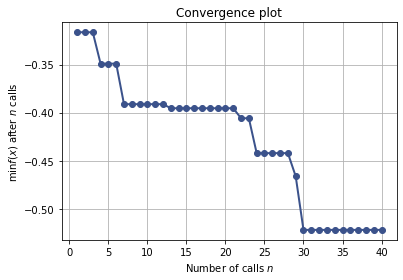

In [117]:
from skopt.plots import plot_convergence, plot_objective_2D, plot_objective
plot_convergence(search_result) 


In [ ]:
dim_names = ['learning_rate', 'num_dense_layers', 'num_dense_nodes', 'activation', 'dropout', 'weight_init']

from matplotlib.pyplot import figure

figure(figsize=(10, 12), dpi=80)

plot_objective(result=search_result, dimensions=dim_names, size=3.5)
plt.savefig("all_dimen.png", dpi=400)

## Uncertainty with HPO Models

In [20]:
# load the model
# paths = ["./hpo_models2/", "./hpo_models3/"]
paths = ['./hpo_models/']
model_paths = []
for path in paths:
    models = os.listdir(path)
    models = [path + model for model in models]
    model_paths.extend(models)
    

model_paths = ['./models-baseline/', './models-attention/', './models-optimized/', './models-v2/', './models-v3/']

#Test Predictions in the entire test set
mc_predictions = []
for x in model_paths:
    if 'model' in x:
        custom_objects = {"dice_coef": dice_coef, "iou_coef": iou_coef, "accuracy": tf.keras.metrics.Accuracy(),'focal_tversky_loss': focal_tversky_loss}
        model = tf.keras.models.load_model(x, custom_objects=custom_objects)

        # predict digit
        y_p = model.predict(test_ds)

        if np.isnan(y_p).any():
            del model
            K.clear_session()
            continue

        y_p = y_p.reshape(y_p.shape[0]*y_p.shape[1]*y_p.shape[2], 1)
        y_p = np.append(y_p, 1 - y_p[:, ], axis=-1)     

        temp = y_p.copy()
        y_p[:, 0] = temp[:, 1]
        y_p[:, 1] = temp[:, 0]

        del temp

        mc_predictions.append(y_p)

        del model
        K.clear_session()


In [21]:
#Calculate the ensable mean and std
p = np.array(mc_predictions)
y_mean = p.mean(axis=0)
y_std = p.std(axis=0)

In [22]:
# Get labels and calculate predictions from mean probabilities
labels = []
for img, lab in test_ds:
    labels.append(lab.numpy())

labels = np.concatenate(labels)
labels = labels.reshape(labels.shape[0]*labels.shape[1]*labels.shape[2], 1)

mc_ensemble_pred = (y_mean[:, 1] > 0.5).astype(np.float32)

In [23]:
# Reshape label and predictions

labels = labels.reshape(-1, 64, 64, 1)
mc_ensemble_pred = mc_ensemble_pred.reshape(-1, 64, 64, 1)
labels.shape, mc_ensemble_pred.shape

((60161, 64, 64, 1), (60161, 64, 64, 1))

In [24]:
# Calculate dice score
with tf.device('/CPU:0'):
    diceScore = dice_coef(labels.astype("float32"), mc_ensemble_pred.astype("float32"))
    print(f'Dice Coefficient score: {diceScore}')

Dice Coefficient score: 0.6019659638404846


In [25]:
with tf.device('/CPU:0'):

    m = tf.keras.metrics.Accuracy()
    m.reset_state()
    m.update_state(labels, mc_ensemble_pred)

    print(f'Accuracy: {m.result().numpy()}')


Accuracy: 0.8235896229743958


In [26]:
roc_auc_score(labels.flatten(), y_mean[:, 1])

0.8395335341451444

Random Agent: ROC AUC=0.500
U-Net: ROC AUC=0.840


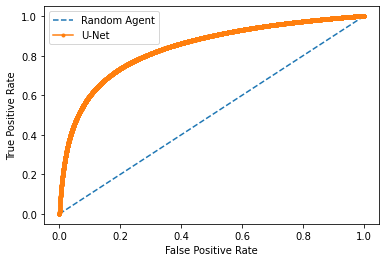

In [27]:
testy = labels.flatten()
ns_probs = [0 for _ in range(len(testy))]
lr_probs = y_mean[:, 1]
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)

ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)

print('Random Agent: ROC AUC=%.3f' % (ns_auc))
print('U-Net: ROC AUC=%.3f' % (lr_auc))

pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Random Agent')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='U-Net')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

U-Net: f1=0.602 auc=0.691


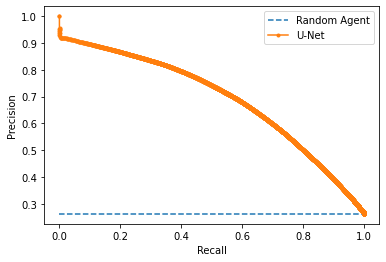

In [28]:
testy = labels.flatten()
lr_probs = y_mean[:, 1]
yhat = mc_ensemble_pred.flatten()


# calculate precision and recall for each threshold
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
# calculate scores
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('U-Net: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Random Agent')
pyplot.plot(lr_recall, lr_precision, marker='.', label='U-Net')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

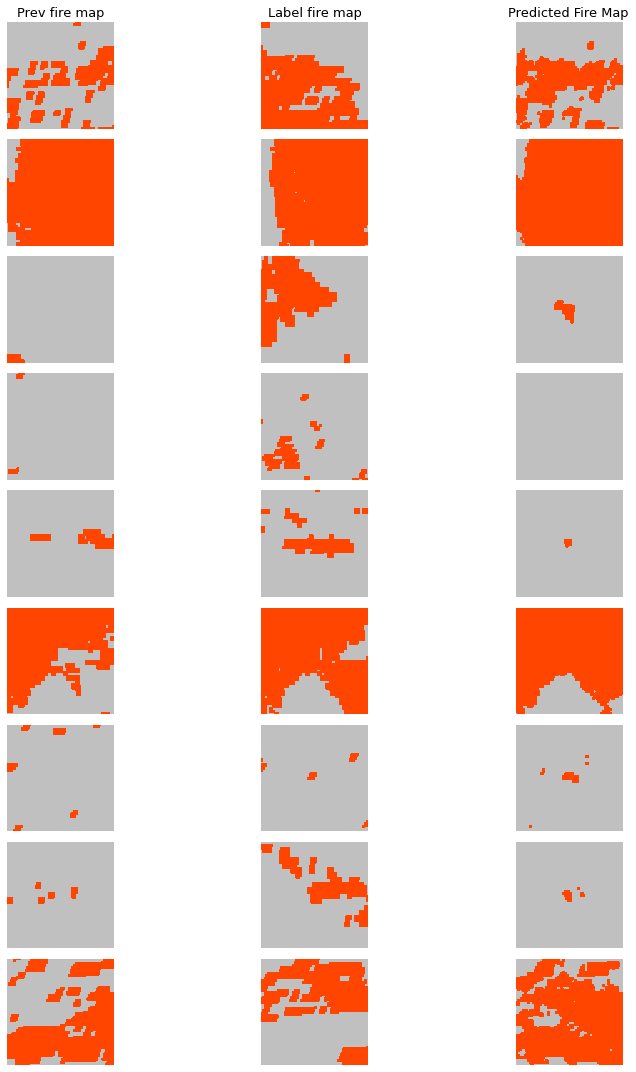

In [31]:
test_iter = iter(test_ds)
inputs, labels = next(test_iter) 


fig = plt.figure(figsize=(15,15))



TITLES = ['Prev fire map', 'Label fire map', 'Predicted Fire Map']
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
n_rows = 9
for i in range(n_rows):
  for j in range(len(TITLES)):
    plt.subplot(n_rows, 3 + 1, i * (3 + 1) + j + 1)
    if i == 0:
      plt.title(TITLES[j], fontsize=13)
    if j == 0 :
      plt.imshow(inputs[i, :, :, -1], cmap=CMAP, norm=NORM)
    if j == 1:
      plt.imshow(labels[i, :, :], cmap=CMAP, norm=NORM)
    if j == 2:
      plt.imshow(mc_ensemble_pred.reshape(-1, 64, 64, 1)[i], cmap=CMAP, norm=NORM) 
    plt.axis('off')
plt.tight_layout()

Text(0.5, 1.0, 'True and predicted class')

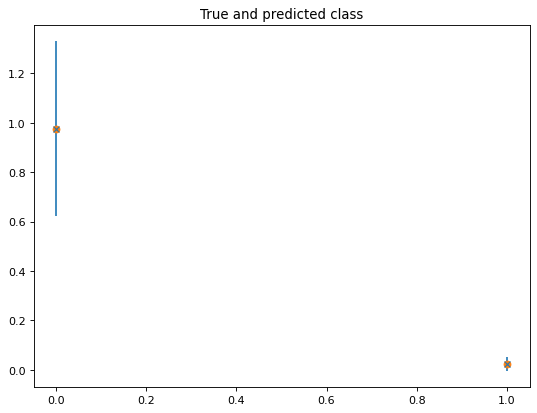

In [108]:
mean_images = y_mean.reshape(-1, 64, 64, 2)
image = mean_images[3]
image.resize(4096, 2)
figure(figsize=(8, 6), dpi=80)

plt.errorbar(range(2), np.mean(image, axis=0), yerr=np.std(image, axis=0), linestyle='None', marker='x')
plt.plot(range(2), np.mean(image, axis=0), linestyle='None', marker='o')
plt.title('True and predicted class')

### Threshold Optimization

In [39]:
i = 0
probPreds = []
labels = []
for img, lab in valid_ds:
    probPred = unet.predict(img).astype("float32")
    
    probPreds.append(probPred)
    labels.append(lab.numpy())

    i += 1
    if i == -1:
        break

probPreds = np.concatenate(probPreds)
labels = np.concatenate(labels)

Best Threshold: 0.19419999420642853 with G-Mean: 0.7178
FPR: 0.2296, TPR: 0.6688


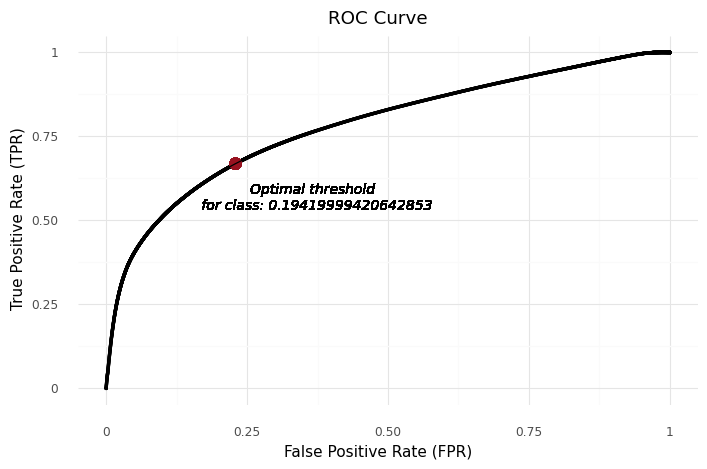

<ggplot: (113607597608)>

In [40]:
fpr, tpr, thresholds = roc_curve(labels.flatten(), probPreds.flatten())
# Plot the ROC curve
df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})
df_fpr_tpr.head()


# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

Best Threshold: 0.21729999780654907 with Youden J statistic: 0.7164
FPR: 0.2044, TPR: 0.6451


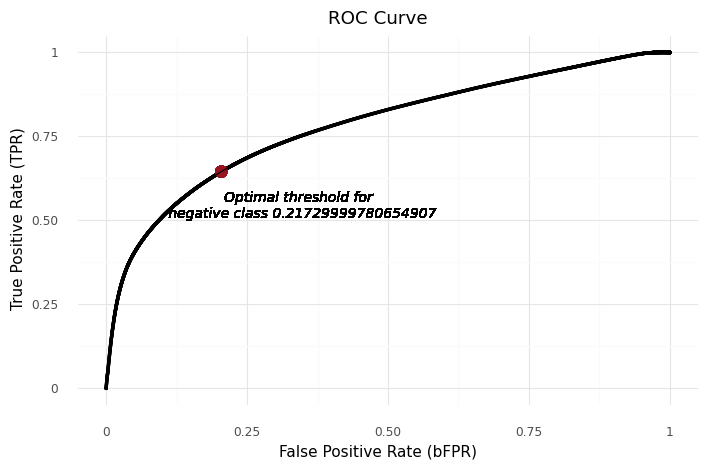

<ggplot: (113892297256)>

In [41]:
# Calculate the Youden's J statistic
youdenJ = tpr - fpr

# Find the optimal threshold
index = np.argmax(youdenJ)
thresholdOpt = round(thresholds[index], ndigits = 4)
youdenJOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with Youden J statistic: {}'.format(thresholdOpt, youdenJOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create a data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    # Annotate the text
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold for \n negative class {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (bFPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

Best Threshold: 0.33500000834465027 with F-Score: 0.5436
Recall: 0.5516, Precision: 0.5359


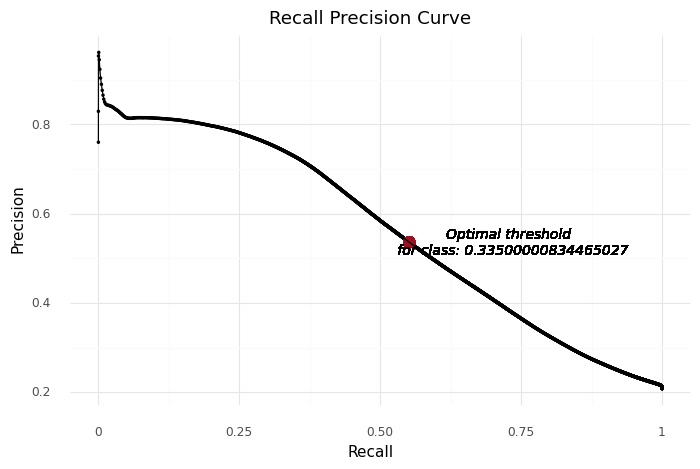

<ggplot: (113526739426)>

In [42]:
# Create the Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(labels.flatten(), probPreds.flatten())

# Plot the ROC curve
df_recall_precision = pd.DataFrame({'Precision':precision[:-1],
                                    'Recall':recall[:-1],
                                    'Threshold':thresholds})
df_recall_precision.head()


# Calculate the f-score
fscore = (2 * precision * recall) / (precision + recall)

# Find the optimal threshold
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
recallOpt = round(recall[index], ndigits = 4)
precisionOpt = round(precision[index], ndigits = 4)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))
print('Recall: {}, Precision: {}'.format(recallOpt, precisionOpt))

# Create a data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_recall_precision)+
    geom_point(aes(x = 'Recall',
                   y = 'Precision'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = recallOpt,
                   y = precisionOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'Recall',
                  y = 'Precision'))+
    # Annotate the text
    geom_text(aes(x = recallOpt,
                  y = precisionOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.18,
              nudge_y = 0,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Recall Precision Curve')+
    xlab('Recall')+
    ylab('Precision')+
    theme_minimal()
)

Length of sequence: 20
Best Threshold: 0.35 with F-Score: 0.5434


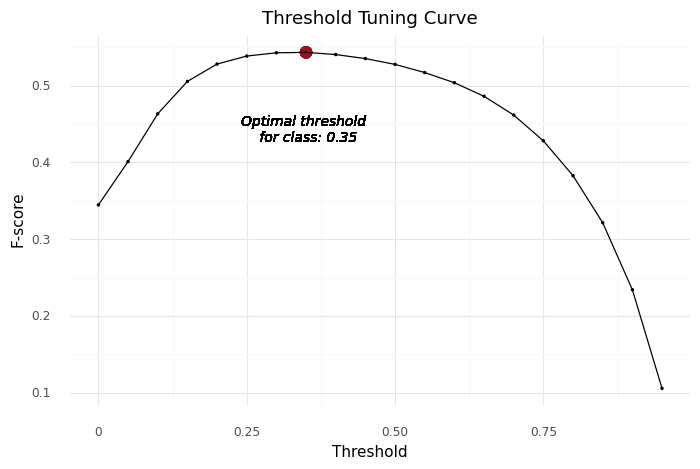

<ggplot: (113892184754)>

In [43]:
# Array for finding the optimal threshold
thresholds = np.arange(0.0, 1.0, 0.05)
fscore = np.zeros(shape=(len(thresholds)))
print('Length of sequence: {}'.format(len(thresholds)))

# Fit the model
for index, elem in enumerate(thresholds):
    # Corrected probabilities
    y_pred_prob = (probPreds.flatten() > elem).astype('int')
    # Calculate the f-score
    fscore[index] = f1_score(labels.flatten(), y_pred_prob)

# Find the optimal threshold
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))

# Plot the threshold tuning
df_threshold_tuning = pd.DataFrame({'F-score':fscore,
                                    'Threshold':thresholds})
df_threshold_tuning.head()

plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_threshold_tuning)+
    geom_point(aes(x = 'Threshold',
                   y = 'F-score'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = thresholdOpt,
                   y = fscoreOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'Threshold',
                   y = 'F-score'))+
    # Annotate the text
    geom_text(aes(x = thresholdOpt,
                  y = fscoreOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Threshold Tuning Curve')+
    xlab('Threshold')+
    ylab('F-score')+
    theme_minimal()
)

### Evaluation 

In [23]:
test_iter = iter(test_ds)
inputs, labels = next(test_iter) 
preds = (unet.predict(inputs) > 0.3).astype("float32")


In [21]:
i = 0
probPreds = []
preds = []
labels = []
for img, lab in test_ds:
    probPred = unet.predict(img).astype("float32")
    pred = (probPred > 0.3).astype("float32")
    
    probPreds.append(probPred)
    preds.append(pred)
    labels.append(lab.numpy())

    i += 1
    if i == -1:
        break

probPreds = np.concatenate(probPreds)
preds = np.concatenate(preds)
labels = np.concatenate(labels)

In [22]:
labels.shape, preds.shape, probPreds.shape

((53544, 64, 64, 1), (53544, 64, 64, 1), (53544, 64, 64, 1))

In [26]:
with tf.device('/CPU:0'):

    m = tf.keras.metrics.Accuracy()
    m.reset_state()
    m.update_state(labels, preds)

    print(f'Accuracy: {m.result().numpy()}')


Accuracy: 0.7635585069656372


In [27]:
with tf.device('/CPU:0'):
    diceScore = dice_coef(labels, preds)
    print(f'Dice Coefficient score: {diceScore}')


Dice Coefficient score: 0.6675103902816772


Random Agent: ROC AUC=0.500
U-Net: ROC AUC=0.837


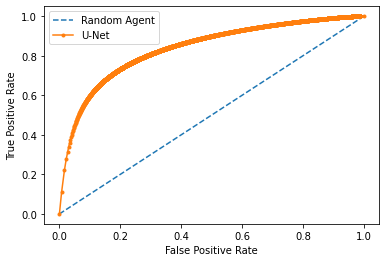

In [28]:

testy = labels.flatten()
ns_probs = [0 for _ in range(len(testy))]
lr_probs = probPreds.flatten()
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)

ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)

print('Random Agent: ROC AUC=%.3f' % (ns_auc))
print('U-Net: ROC AUC=%.3f' % (lr_auc))

pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Random Agent')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='U-Net')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

U-Net: f1=0.668 auc=0.724


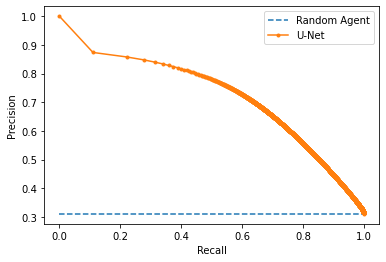

In [29]:
testy = labels.flatten()
lr_probs = probPreds.flatten()
yhat = preds.flatten()


# calculate precision and recall for each threshold
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
# calculate scores
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('U-Net: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Random Agent')
pyplot.plot(lr_recall, lr_precision, marker='.', label='U-Net')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

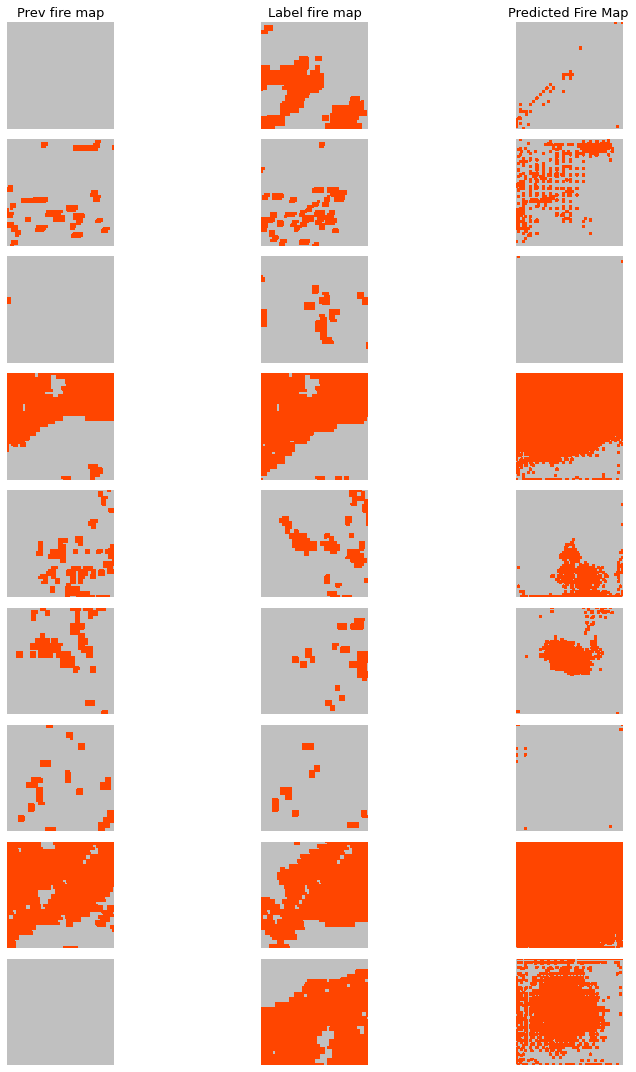

In [73]:
test_iter = iter(test_ds)
x  = 1
for i in range(x):
    inputs, labels = next(test_iter) 
sampleInputs, sampleLabels = next(test_iter) 
samplePreds = (unet.predict(sampleInputs) > 0.3).astype("float32")


fig = plt.figure(figsize=(15,15))



TITLES = ['Prev fire map', 'Label fire map', 'Predicted Fire Map']
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
n_rows = 9
for i in range(n_rows):
  for j in range(len(TITLES)):
    plt.subplot(n_rows, 3 + 1, i * (3 + 1) + j + 1)
    if i == 0:
      plt.title(TITLES[j], fontsize=13)
    if j == 0 :
      plt.imshow(sampleInputs[i, :, :, -1], cmap=CMAP, norm=NORM)
    if j == 1:
      plt.imshow(sampleLabels[i, :, :], cmap=CMAP, norm=NORM)
    if j == 2:
      plt.imshow(samplePreds[i, :, :], cmap=CMAP, norm=NORM) 
    plt.axis('off')
plt.tight_layout()